# DESI PV Y1 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-cluster joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **30 July 2024**

**Note:** This requires using a subclassed version of `hyperfit`.

Potential updates to this notebook:
* Improved identification of spiral galaxy morphologies in the SGA (currently using LEDA morphological classification).
* Larger statistics of SN Ia calibrators with rotation curve measurements and independent distance moduli.

In [24]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

# Custom functions / classes
import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi

In [3]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$

In [4]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
# sgapath = '.'
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')

sgatab = Table.read(sgafits)
sgatab

<Table length=10278>
 SGA_ID    SGA_GALAXY    ...      V_0p4R26         V_0p4R26_err   
 int64      bytes16      ...      float64            float64      
------- ---------------- ... ------------------ ------------------
     38      SGA-2020 38 ...  132.3208048632948 2.6948192386790226
     55      SGA-2020 55 ...   81.2209561056899 3.2082484299586027
    117     SGA-2020 117 ...  197.0582628022927  8.878686505532894
    223     SGA-2020 223 ...  72.53747045038213  4.402000322517785
    581     SGA-2020 581 ... 139.67033682062663  4.581358764759421
    669     SGA-2020 669 ... 317.17020250644606  5.983871986183279
    731     SGA-2020 731 ...  87.96944798708519 4.2768923546703395
   1135    SGA-2020 1135 ... 231.79954131023922  1.789293325910895
   1158    SGA-2020 1158 ...  186.0391377453151 1.8414976527945948
   1287    SGA-2020 1287 ... 111.59085458153397 11.029031127495571
    ...              ... ...                ...                ...
5002603 SGA-2020 5002603 ... 325.99190466247103 7.2992219447588305
5002677 SGA-2020 5002677 ...   70.4490685679974  9.185726769499391
5002752 SGA-2020 5002752 ... 55.911511491958265  5.417330667527829
5002778 SGA-2020 5002778 ...  150.7507247265663 16.017853419033692
5002994 SGA-2020 5002994 ...  71.50194425699918     4.354163965953
5003016 SGA-2020 5003016 ...  106.2178163898393 1.9902770334558844
5003025 SGA-2020 5003025 ...  46.99842244334801 3.7071900456924776
5003042 SGA-2020 5003042 ... 138.76988850551547 16.323908084526206
5003044 SGA-2020 5003044 ...  196.1601334484247 17.809802319960514
5003075 SGA-2020 5003075 ...  83.17494755247105  6.566340714296447

## Load Morphological Classification using the Random Forest

As an alternative to morphological classification of the galaxies, we also produced a classification based on a random forest (J. Largett, University of Rochester, in preparation). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [5]:
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

<Table length=10278>
  SGA_ID  Predicted_Type_RF ... Predicted_Type_EvenTraining_knn
 float64        str10       ...              str10             
--------- ----------------- ... -------------------------------
     38.0           Unknown ...                      Lenticular
     55.0           Unknown ...                       Irregular
    117.0           Unknown ...                      Lenticular
    223.0           Unknown ...                       Irregular
    581.0            Spiral ...                       Irregular
    669.0            Spiral ...                      Elliptical
    731.0         Irregular ...                       Irregular
   1135.0            Spiral ...                      Elliptical
   1158.0            Spiral ...                      Lenticular
   1287.0         Irregular ...                      Elliptical
      ...               ... ...                             ...
5002603.0            Spiral ...                      Lenticular
5002677.0         Irregular ...                      Lenticular
5002752.0         Irregular ...                      Lenticular
5002778.0         Irregular ...                       Irregular
5002994.0         Irregular ...                      Lenticular
5003016.0         Irregular ...                      Elliptical
5003025.0         Irregular ...                       Irregular
5003042.0         Irregular ...                       Irregular
5003044.0        Elliptical ...                      Lenticular
5003075.0         Irregular ...                      Lenticular

In [6]:
#- Create an overall record of the RF prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

#- Select records where the 2 of 3 RF selections agree.
rf_classes = ['Elliptical', 'Irregular', 'Lenticular', 'Spiral']
for rf_class in rf_classes:
    is_class = ((ai_morphtab['Predicted_Type_RF']==rf_class) & (ai_morphtab['Predicted_Type_UnevenTraining_knn']==rf_class)) | \
               ((ai_morphtab['Predicted_Type_RF']==rf_class) & (ai_morphtab['Predicted_Type_EvenTraining_knn']==rf_class)) | \
               ((ai_morphtab['Predicted_Type_UnevenTraining_knn']==rf_class) & (ai_morphtab['Predicted_Type_EvenTraining_knn']==rf_class))

    ai_morphtab['Predicted_Type'][is_class] = rf_class

ai_morphtab

<Table length=10278>
  SGA_ID  Predicted_Type_RF ... Predicted_Type_EvenTraining_knn Predicted_Type
 float64        str10       ...              str10                  str10     
--------- ----------------- ... ------------------------------- --------------
     38.0           Unknown ...                      Lenticular     Undecided 
     55.0           Unknown ...                       Irregular     Undecided 
    117.0           Unknown ...                      Lenticular     Undecided 
    223.0           Unknown ...                       Irregular     Undecided 
    581.0            Spiral ...                       Irregular         Spiral
    669.0            Spiral ...                      Elliptical         Spiral
    731.0         Irregular ...                       Irregular      Irregular
   1135.0            Spiral ...                      Elliptical         Spiral
   1158.0            Spiral ...                      Lenticular     Lenticular
   1287.0         Irregular ...                      Elliptical     Undecided 
      ...               ... ...                             ...            ...
5002603.0            Spiral ...                      Lenticular         Spiral
5002677.0         Irregular ...                      Lenticular     Undecided 
5002752.0         Irregular ...                      Lenticular     Undecided 
5002778.0         Irregular ...                       Irregular      Irregular
5002994.0         Irregular ...                      Lenticular     Undecided 
5003016.0         Irregular ...                      Elliptical     Undecided 
5003025.0         Irregular ...                       Irregular      Irregular
5003042.0         Irregular ...                       Irregular      Irregular
5003044.0        Elliptical ...                      Lenticular     Undecided 
5003075.0         Irregular ...                      Lenticular     Undecided

In [7]:
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]

### Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* $i > 45^\circ$
* Spiral-type morphology
* [Passed visual inspection - applied in SV]

The first two items have already been applied.

In [8]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph

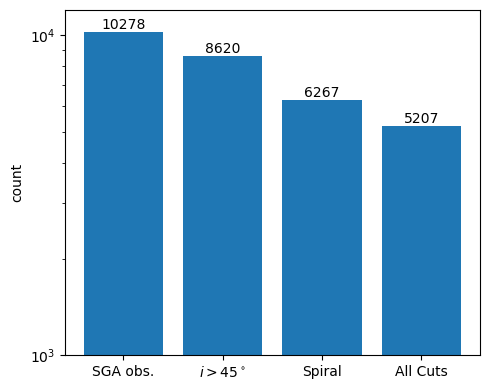

In [9]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    'Spiral' : np.sum(is_good_morph),
    'All Cuts' : np.sum(is_good_sga)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count', yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('TF_Y1_SGA_Vrot_cuts.png', dpi=150);

### Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [10]:
zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptab = Table.read(os.path.join(zeroptpath, 'SGA_SNmatches+secondary.fits'))

In [11]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.in1d(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
zeroptab.write('SGA_distances_0pt_iron.fits', overwrite=True)
zeroptab

<Table length=30>
 SGA_ID    SGA_GALAXY             GALAXY         ...  MU_ERR   MU_SOURCE 
 int64      bytes16              bytes29         ... float64    bytes22  
------- ---------------- ----------------------- ... -------- -----------
 103123  SGA-2020 103123 SDSSJ074708.56+275429.4 ... 0.251383   SN2017ckx
 109750  SGA-2020 109750               PGC007299 ... 0.173532      2005hc
 119118  SGA-2020 119118              PGC1310038 ... 0.340606      2007ba
 122260  SGA-2020 122260 SDSSJ130323.44+271825.0 ...  0.21848      2010ai
 124900  SGA-2020 124900              PGC1111212 ... 0.149593     PS16ayd
 183909  SGA-2020 183909               PGC048632 ...   0.2098      2010ao
 185629  SGA-2020 185629              PGC1313612 ... 0.340606      2007ba
 214395  SGA-2020 214395               PGC049568 ... 0.190198   AT2017cfc
 296124  SGA-2020 296124              PGC1158574 ... 0.168835     PS16axi
 364828  SGA-2020 364828              PGC1259192 ... 0.320886      2006bw
    ...              ...                     ... ...      ...         ...
 995924  SGA-2020 995924               PGC126876 ...  0.21848      2010ai
 999275  SGA-2020 999275              PGC1272499 ... 0.207056 ASASSN-16ct
1031134 SGA-2020 1031134              PGC1097845 ... 0.190198   AT2017cfc
1058861 SGA-2020 1058861               PGC060293 ... 0.263771 ASASSN-15nr
1105542 SGA-2020 1105542              PGC1163310 ... 0.168835     PS16axi
1146354 SGA-2020 1146354                 NGC7782 ... 0.325329      2001da
1290887 SGA-2020 1290887              PGC1173150 ... 0.168835     PS16axi
1356418 SGA-2020 1356418              PGC1108844 ... 0.149593     PS16ayd
1371372 SGA-2020 1371372                 NGC6063 ... 0.365223      1999ac
1385169 SGA-2020 1385169               PGC139231 ... 0.203312     PS15cms

#### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

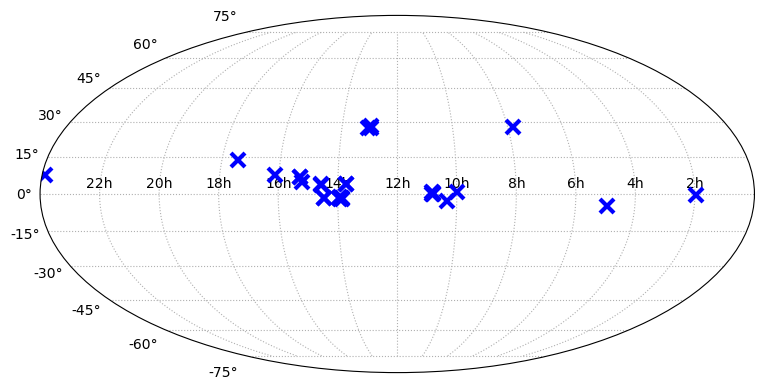

In [12]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'bx', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

#### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [13]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR']**2 + zeroptab['MU_ERR']**2)

## Access Cluster Catalog

These clusters come from the group catalog used by Kourkchi et al. in [*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*](https://iopscience.iop.org/article/10.3847/1538-4357/ab901c), ApJ 896:3, 2020.

Cluster membership is defined as
1. $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_p$, OR
1. $1.5R_{2t} \leq R_p < 3R_{2t}$ AND $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [14]:
clusters = Table.read('../Tully15-Table3.fits')
clusters

<Table length=25474>
f_Nest  Nest   Nmb    PGC1   SGLON   ...  sigV    R2t    sigP     Mlum      CF  
                              deg    ... km / s   Mpc   km / s    Msun          
int16  int32  int16  int32  float64  ... int16  float64 int16   float64  float64
------ ------ ----- ------- -------- ... ------ ------- ------ --------- -------
     1 100001   136   44715  89.6226 ...    886   2.129   1045 1.710e+15    1.65
     1 100002   197   41220 103.0008 ...    670   1.440    707 5.290e+14    1.00
     1 100003   113   43296 156.2336 ...    822   1.520    746 6.230e+14    1.12
     1 100004    81   58265  71.5103 ...    740   2.153   1057 1.770e+15    2.26
     1 100005    61   36487  92.0255 ...    707   1.560    766 6.730e+14    1.58
     1 100006    85   31478 139.4478 ...    648   1.198    588 3.050e+14    1.14
     1 100007    86   56962 108.5182 ...   1261   2.821   1385 3.980e+15    3.30
     1 100008    65   39600  67.2953 ...    209   0.745    366 7.330e+13    1.00
     1 100009    66   59827 173.2412 ...    976   2.095   1029 1.630e+15    2.15
   ...    ...   ...     ...      ... ...    ...     ...    ...       ...     ...
     2 212373     1    7399 343.4755 ...      0   0.039     19 1.030e+10    1.01
     2 212374     1    5896 257.2666 ...      0   0.039     19 1.030e+10    1.01
     2 212375     1    6595 326.4318 ...      0   0.036     18 8.580e+09    1.02
     2 212376     1     930 271.3800 ...      0   0.031     15 5.410e+09    1.01
     2 212377     1   11329 331.2202 ...      0   0.029     14 4.400e+09    1.03
     2 212378     1   71220 334.7408 ...      0   0.019      9 1.240e+09    1.02
     2 212379     1   13115 354.3256 ...      0   0.019      9 1.160e+09    1.04
     2 212380     1    1034 273.1302 ...      0   0.012      6 3.260e+08    1.01
     2 212381     2 2278902 349.2850 ...     41   0.624    306 4.310e+13    2.30
     2 212382     1 2289671 348.7816 ...      0   0.412    202 1.240e+13    2.31

## Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Tully (2015).

Loop through the data and keep only clusters where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [15]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA'], sgatab_sel['DEC'], unit='deg')
z_sga_desi = sgatab_sel['Z_DESI']

In [16]:
sga_clusters = {}
n_cluster_min = 15

for cluster in tqdm(clusters[['Nest', 'SGLON', 'SGLAT', 'R2t', 'sigP', 'DM']]):
    nest_id = cluster['Nest']
    
    #- Sky coordinates of clusters
    cls_coord = SkyCoord(cluster['SGLON'], cluster['SGLAT'], unit='deg', frame='supergalactic')

    #- Cluster turnaround radii, velocity dispersions, and distance moduli.
    R2t = cluster['R2t']
    sigP = cluster['sigP']
    mu = cluster['DM']

    #- Convert distance moduli to velocities [in km/s]
    dist = 10 * 10**(0.2*mu)
    velo = 100 * (dist*1e-6)

    #- Apply cuts on angular separation
    sep = cls_coord.separation(sga_coords)
    R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
    R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian

    #- Apply cluster cuts.
    in_cluster_1 = (sep < R2t_angle_1p5)  & (z_sga_desi*c_kms > velo - 3*sigP) & (z_sga_desi*c_kms < velo + 3*sigP)
    in_cluster_2 = (sep >= R2t_angle_1p5) & (sep < R2t_angle_3) & (z_sga_desi*c_kms > velo - 2*sigP) & (z_sga_desi*c_kms < velo + 2*sigP)
    in_cluster = in_cluster_1 | in_cluster_2

    if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
        if nest_id in sga_clusters:
            warnings.warn(f'Cluster ID {nest_id} already encountered.', RuntimeWarning)
        sga_clusters[nest_id] = list(sgatab_sel['SGA_ID'][in_cluster])

100%|██████████| 25474/25474 [02:40<00:00, 158.64it/s]


In [17]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  100002  17 galaxies
 2  100007  21 galaxies
 3  100042  19 galaxies
 4  100046  16 galaxies
 5  100058  23 galaxies
 6  100067  32 galaxies
 7  100077  16 galaxies
 8  100081  15 galaxies
 9  100282  26 galaxies
10  101400  26 galaxies
11  101434  19 galaxies
12  101788  24 galaxies
13  101823  15 galaxies
14  102885  18 galaxies
15  103172  17 galaxies
16  103175  19 galaxies
17  103182  30 galaxies
18  103203  23 galaxies
19  103206  15 galaxies
20  103229  20 galaxies
21  103332  15 galaxies


### Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

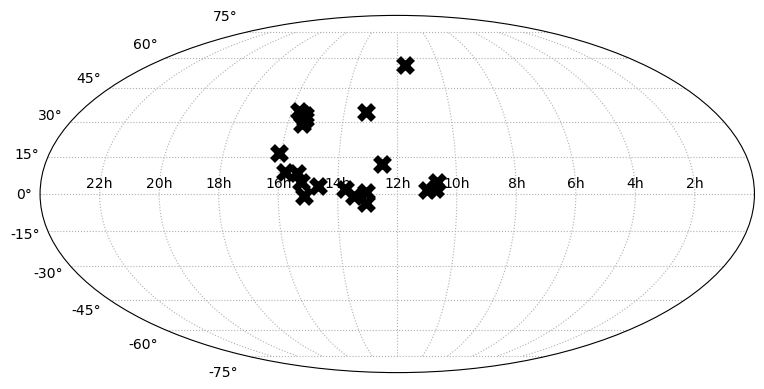

In [18]:
nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.in1d(clusters['Nest'], nest_ids)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('TF_Y1_SGA_Vrot_clusters.png', dpi=150);

In [19]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [20]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord)
    print(f'{cluster_v} +/- {cluster_sigma} km/s')

    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgacat['SGA_ID'], sga_ids)
    z_sga = sgacat['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord, radius=cluster_R2t_4)
    ax.grid()

    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    inner = SphericalCircle(cluster_coord, cluster_R2t_1p5, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner)

    outer = SphericalCircle(cluster_coord, cluster_R2t_3, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_sga, sga_coords.dec.deg, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = np.min(sga_coords.dec.deg) - 0.5
    decmax = np.max(sga_coords.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              decmin, decmax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords.ra.deg, z_sga, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'rD', ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = np.min(sga_coords.ra.deg) - 0.5
    ramax = np.max(sga_coords.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              ramin, ramax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.ra.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.dec.deg, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.0025
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(z_sga_median, 0, 50, colors='r', linestyles='dotted')
    ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Iron Observations of Tully Group {cluster_id}')

    return fig

<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
1492.7944095789974 +/- 707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (220.13676059, 3.3706831)>
8433.347577642775 +/- 545 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.76646719, 1.62439612)>
12647.363474711521 +/- 781 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (197.68010565, 34.27637749)>
11168.632477805635 +/- 635 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 2071 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (160.81499432, 1.91346557)>
22387.211385683422 +/- 1711 km/s
<Sk

/tmp/ipykernel_163066/1761111452.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8), tight_layout=True)


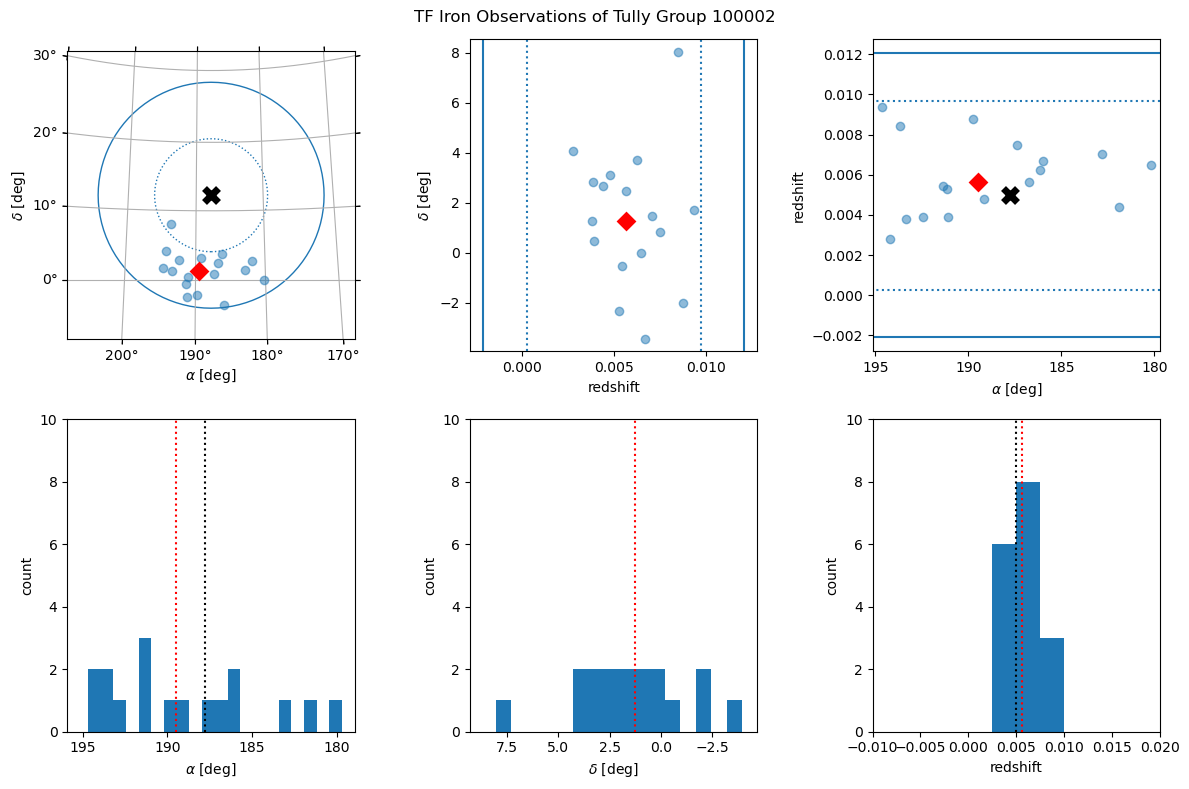

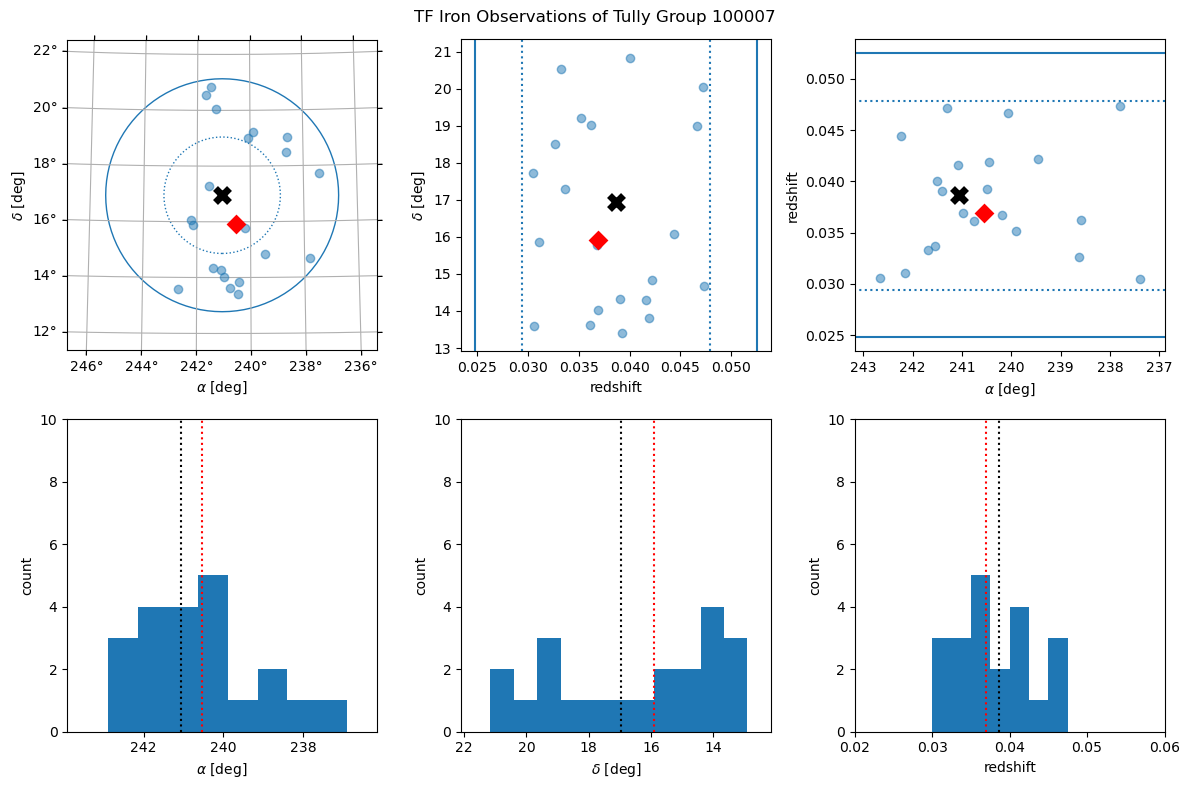

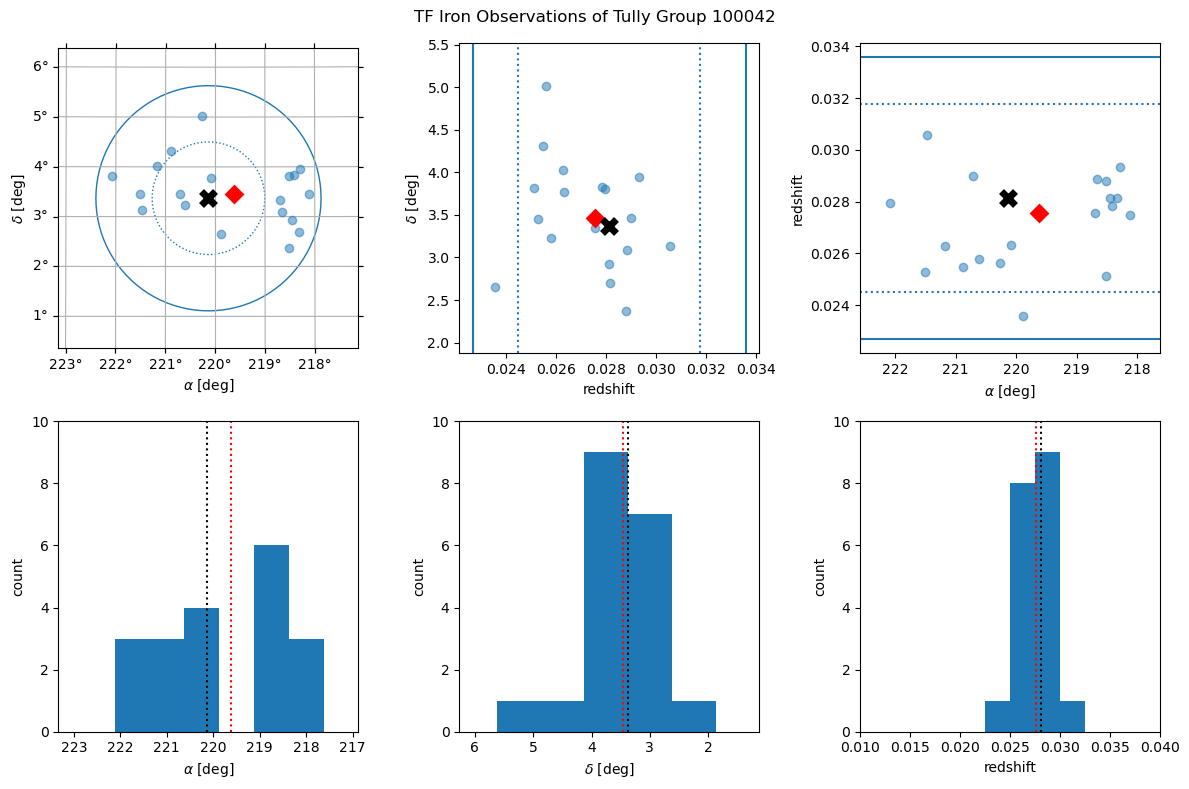

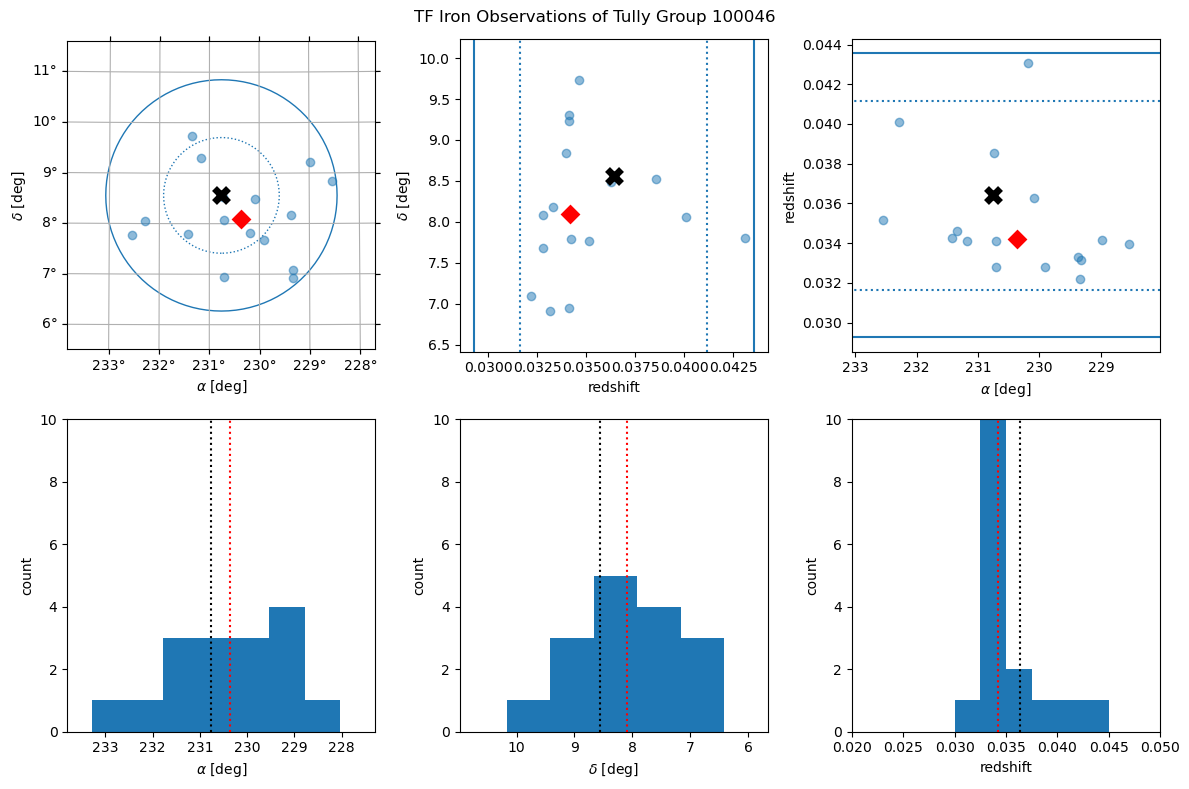

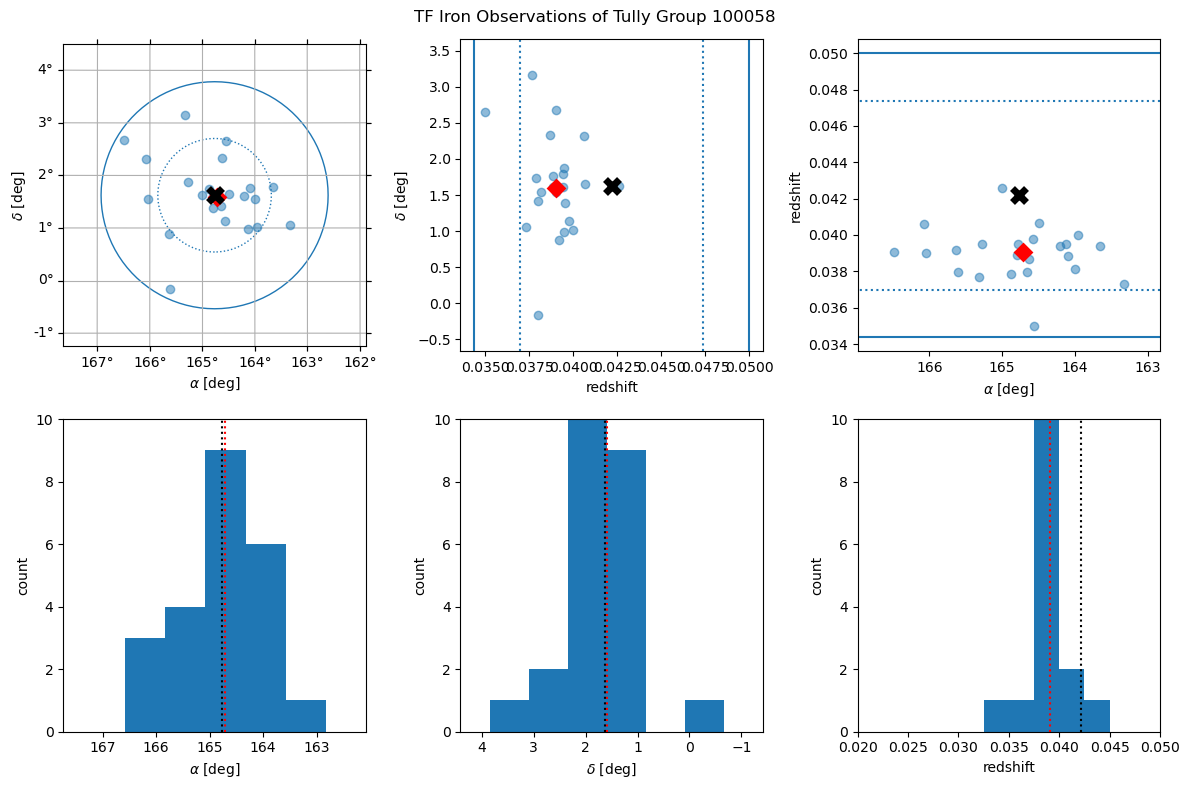

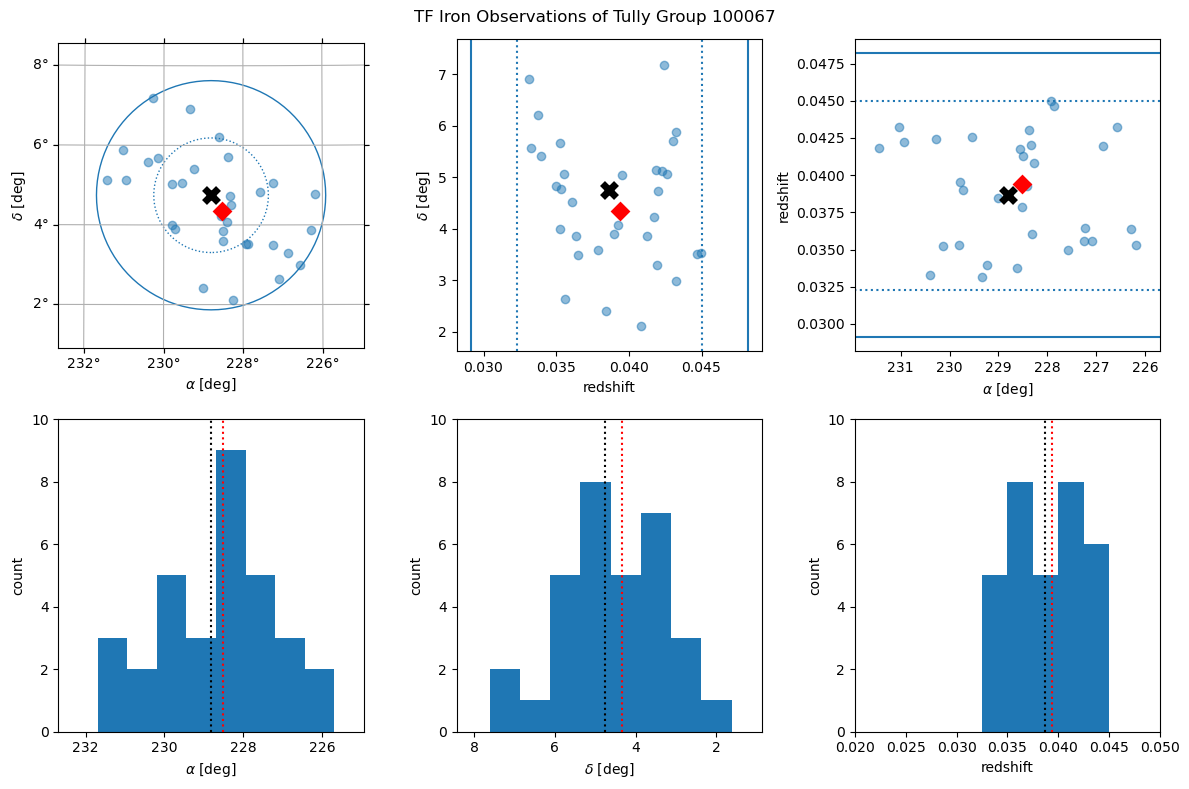

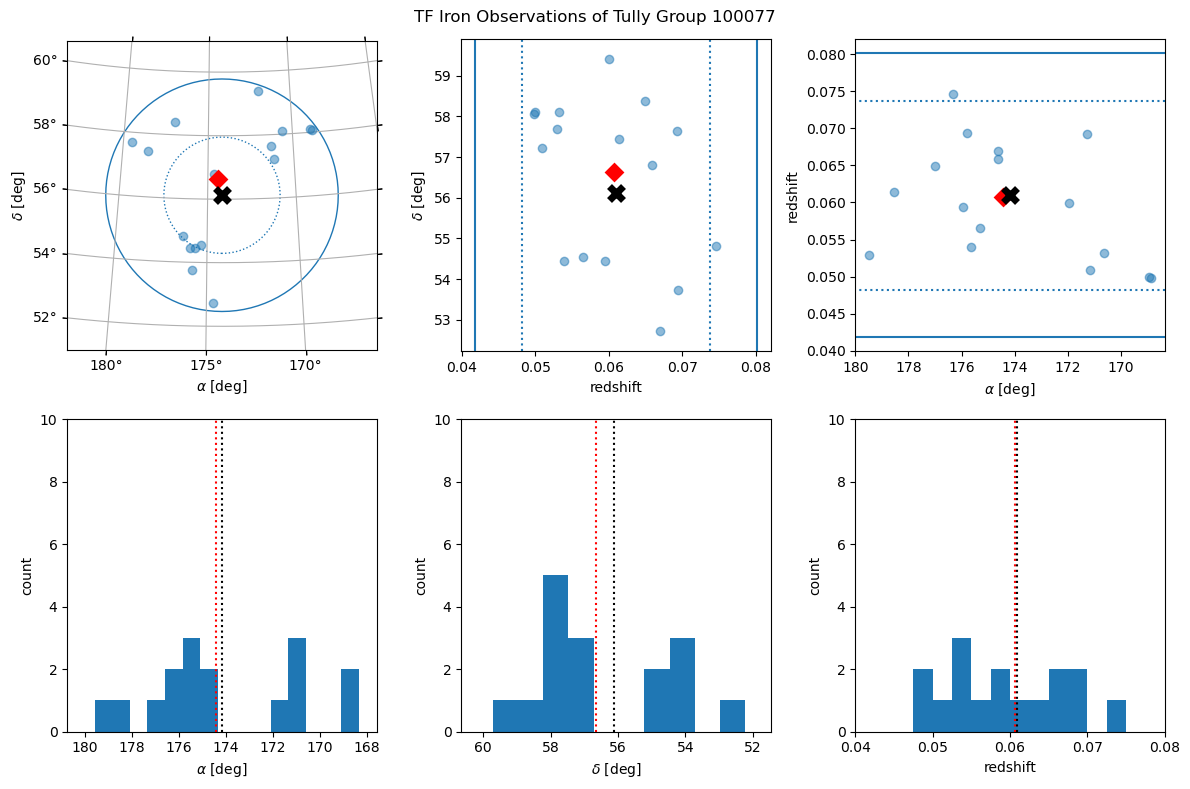

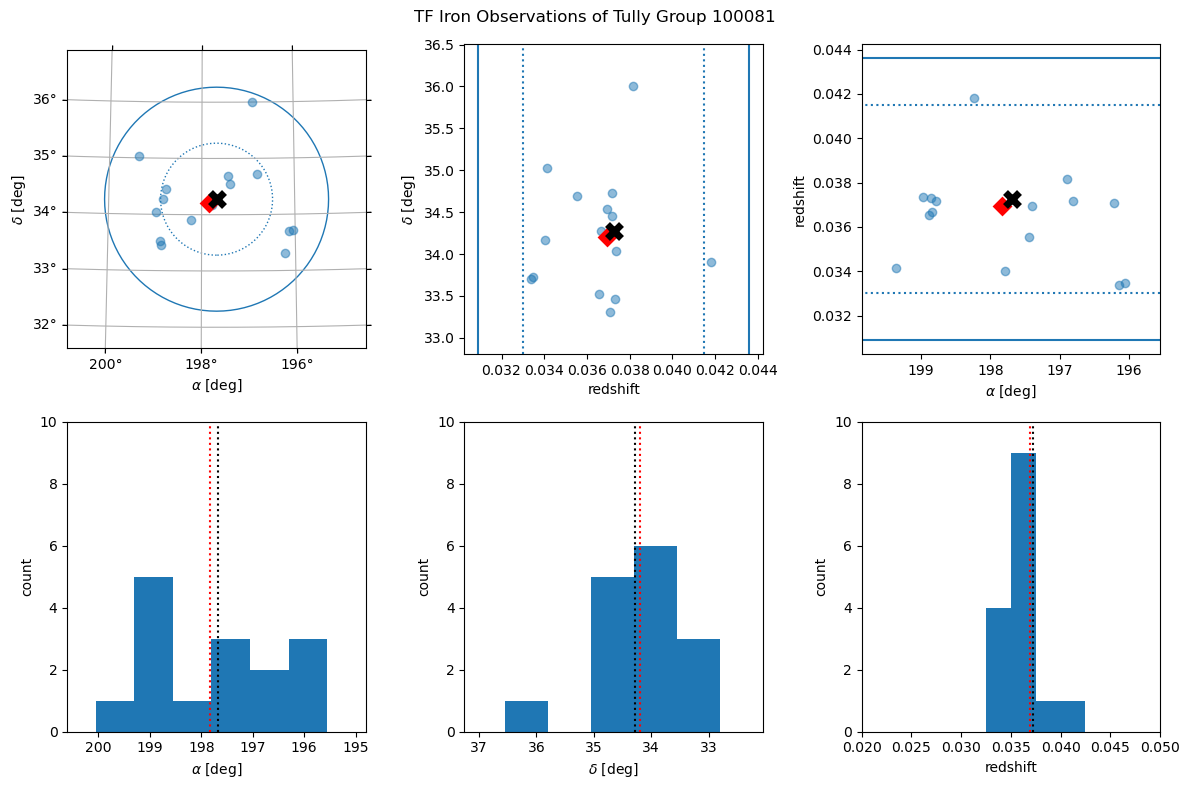

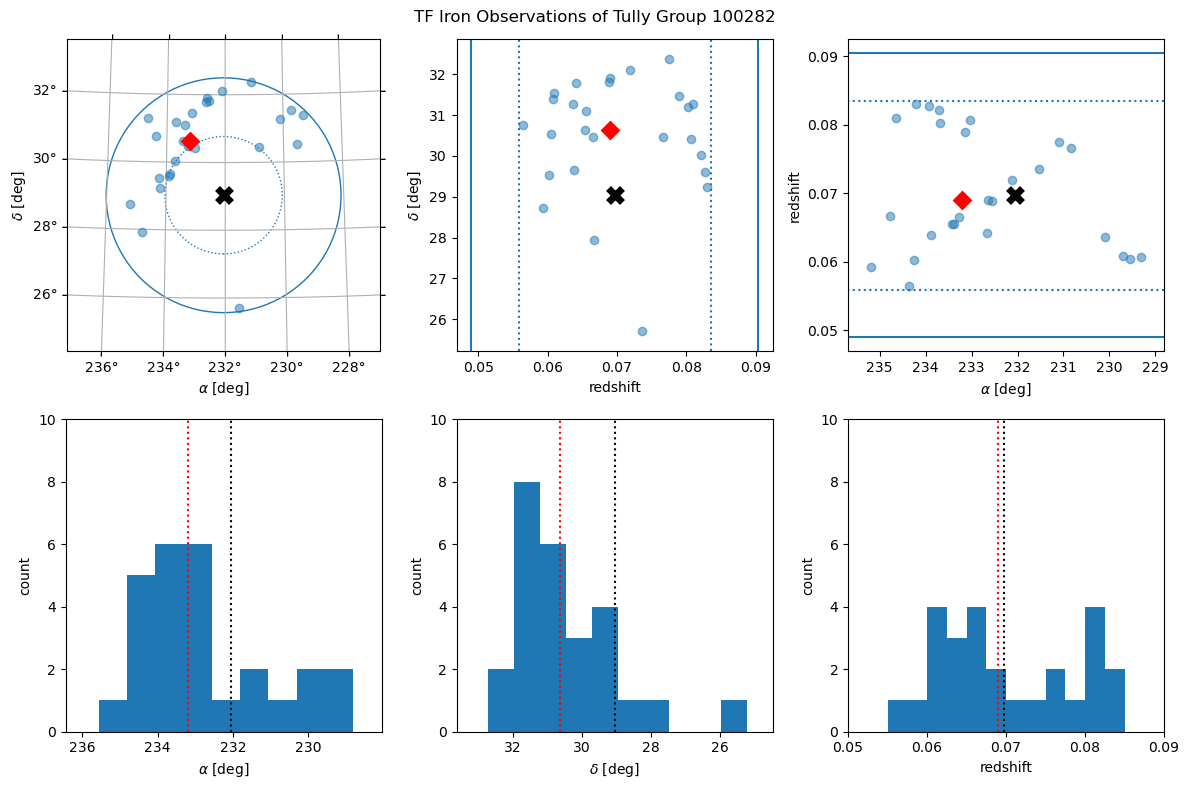

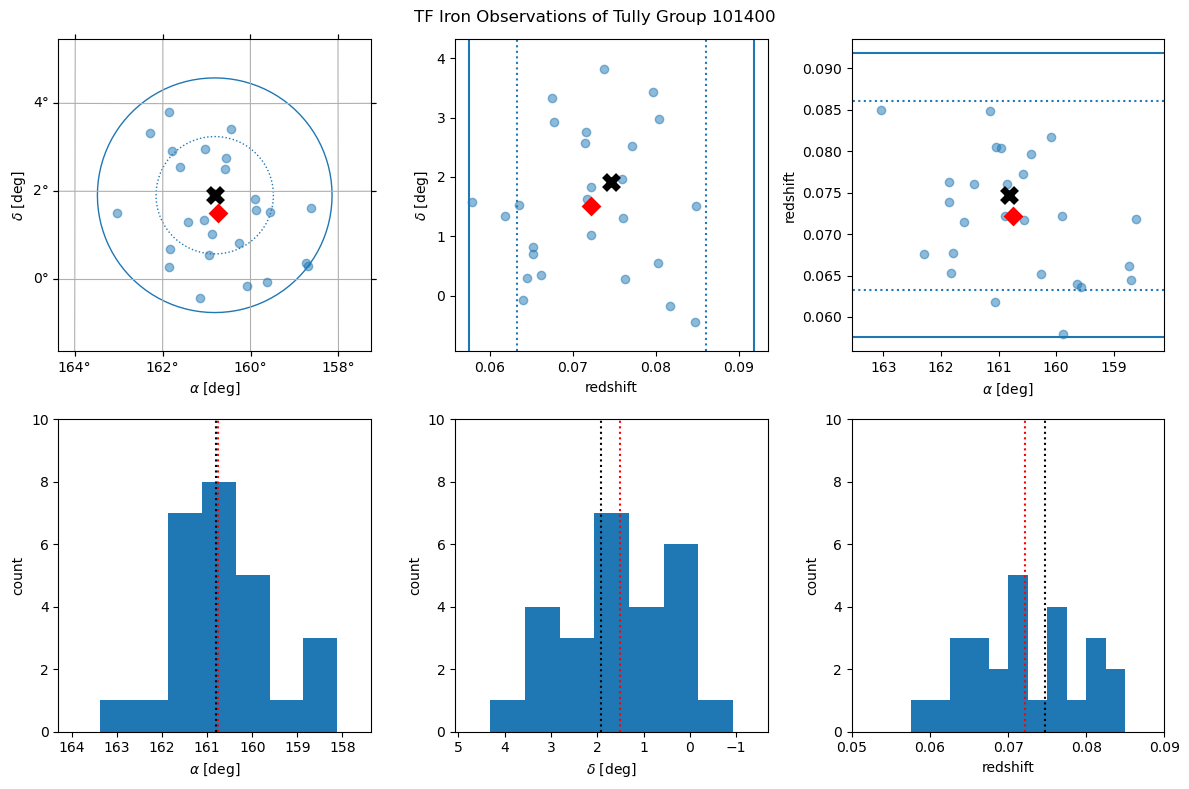

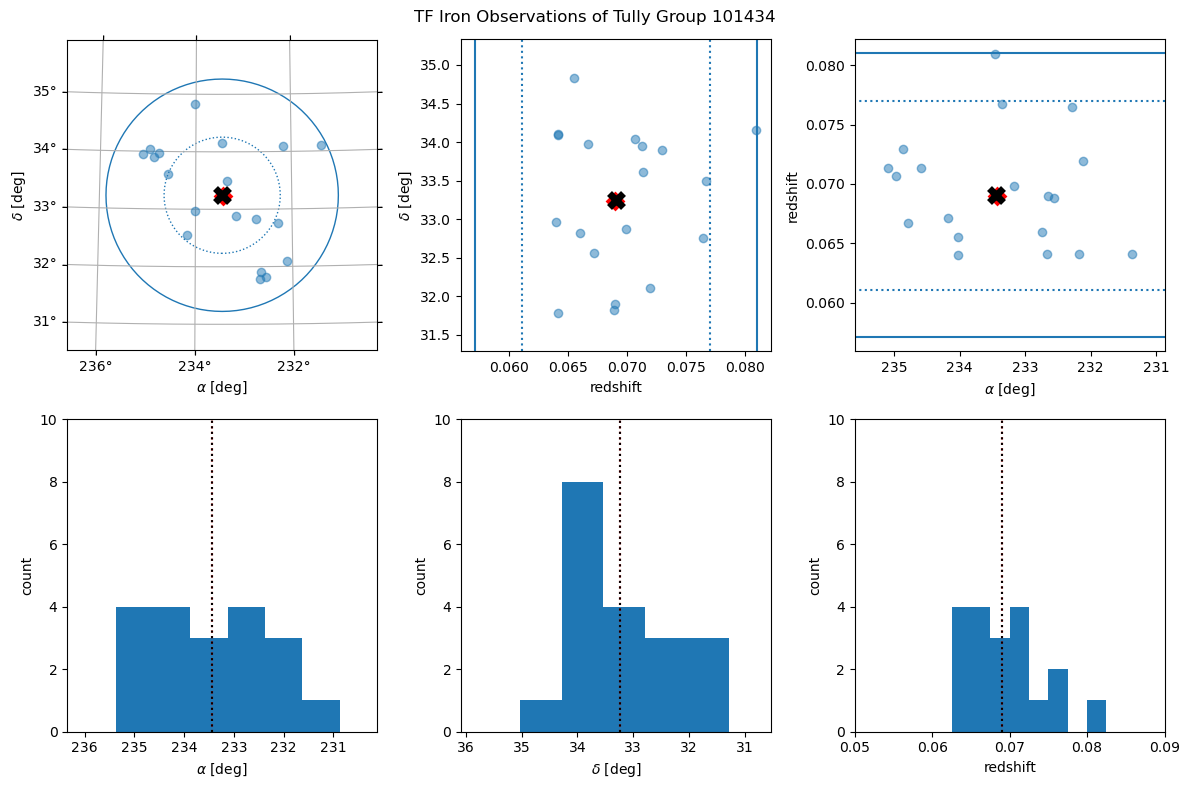

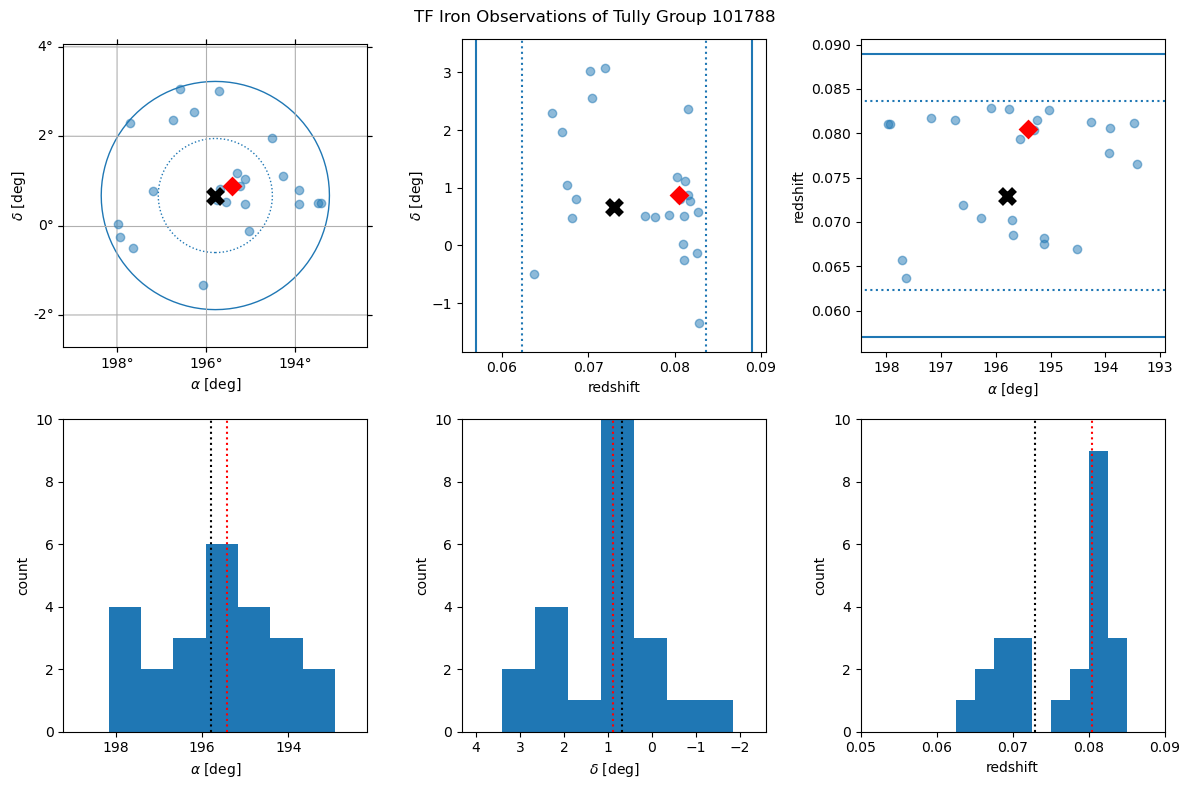

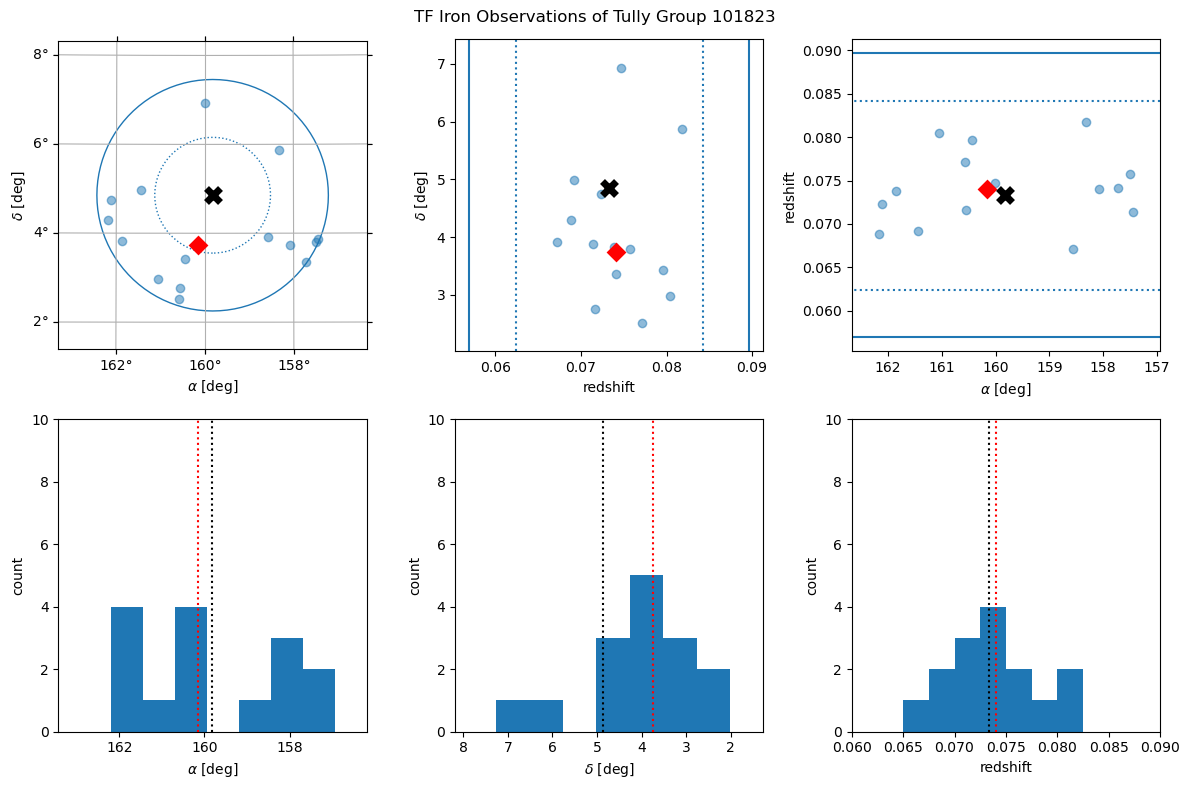

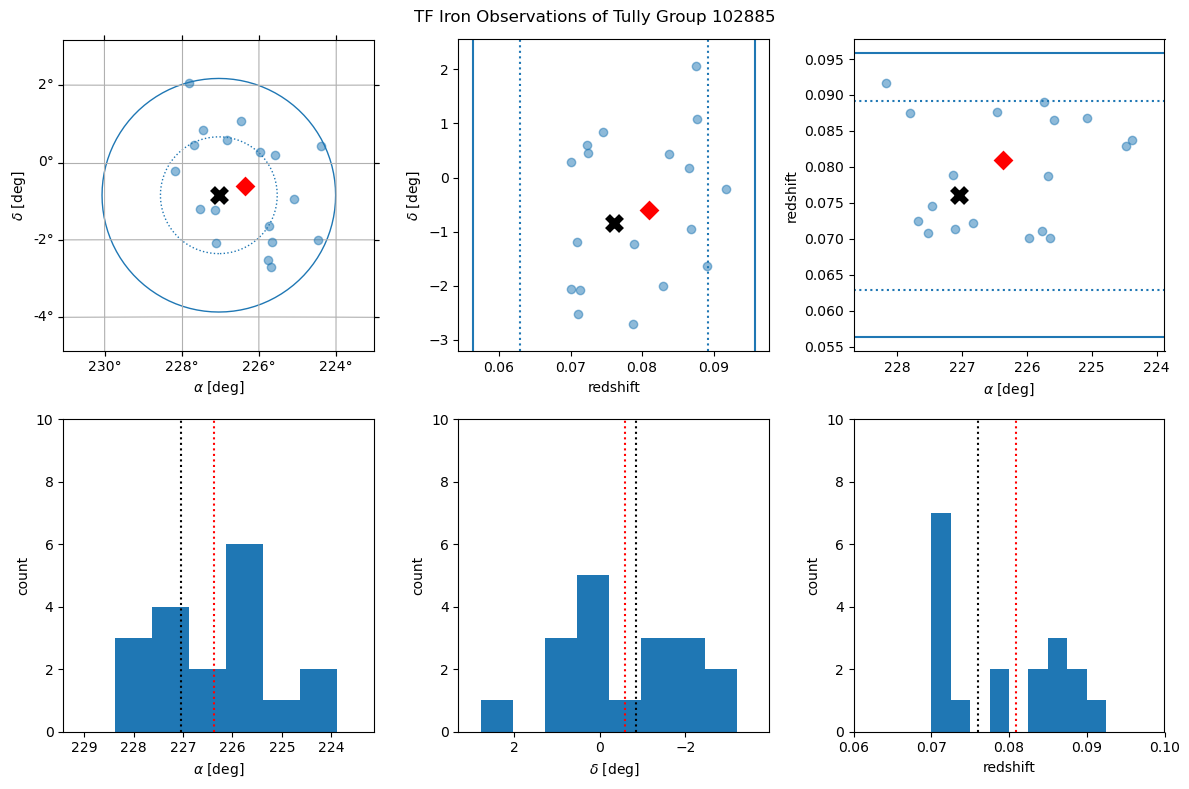

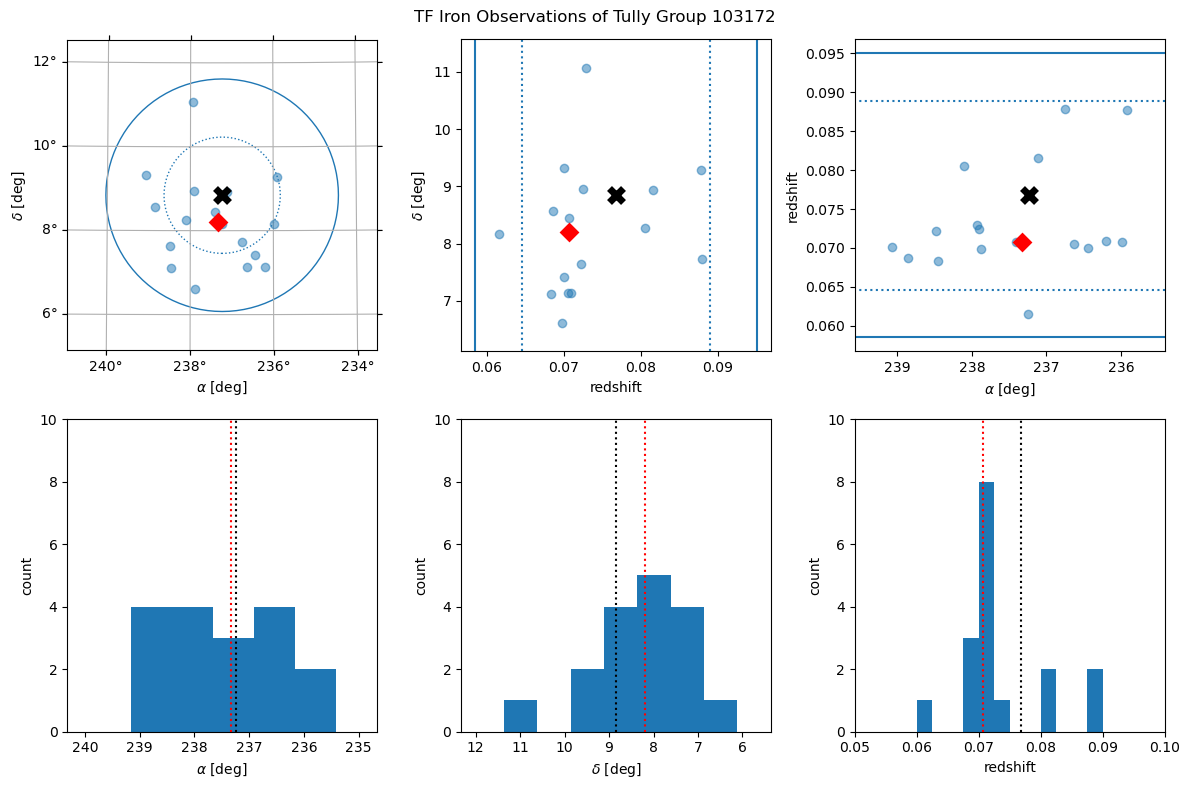

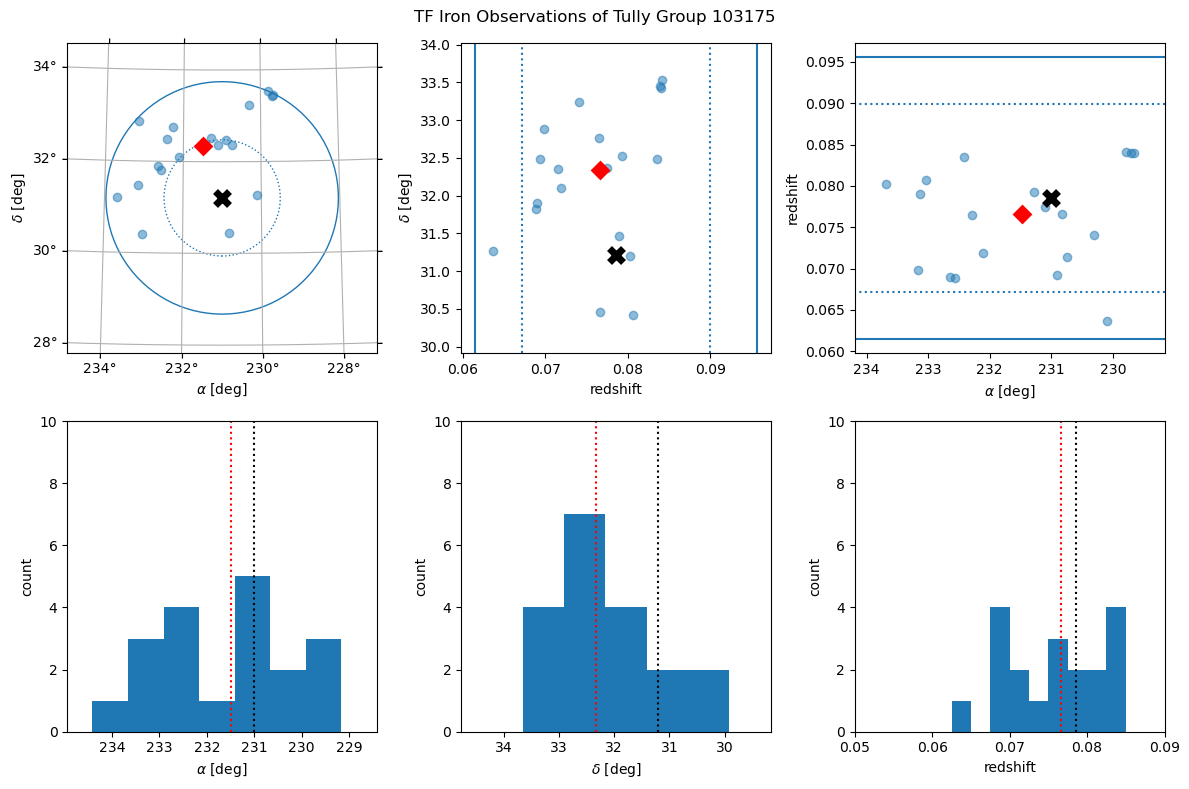

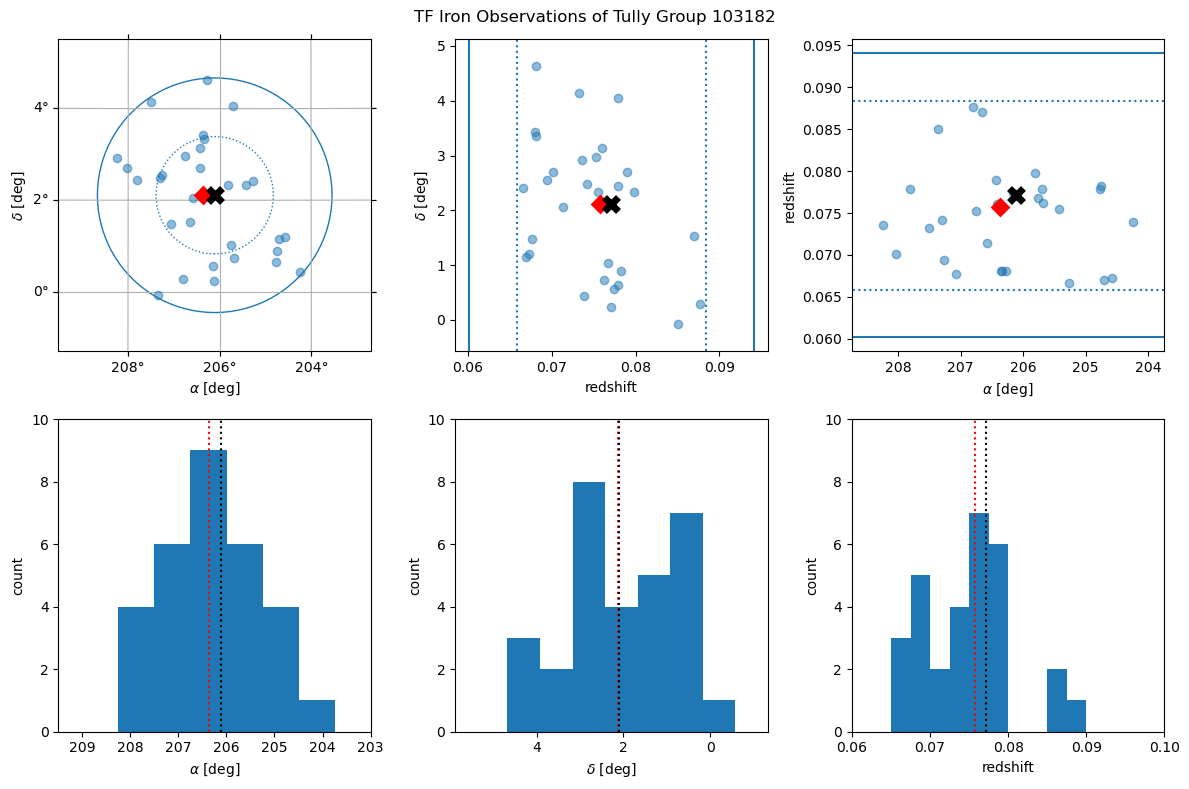

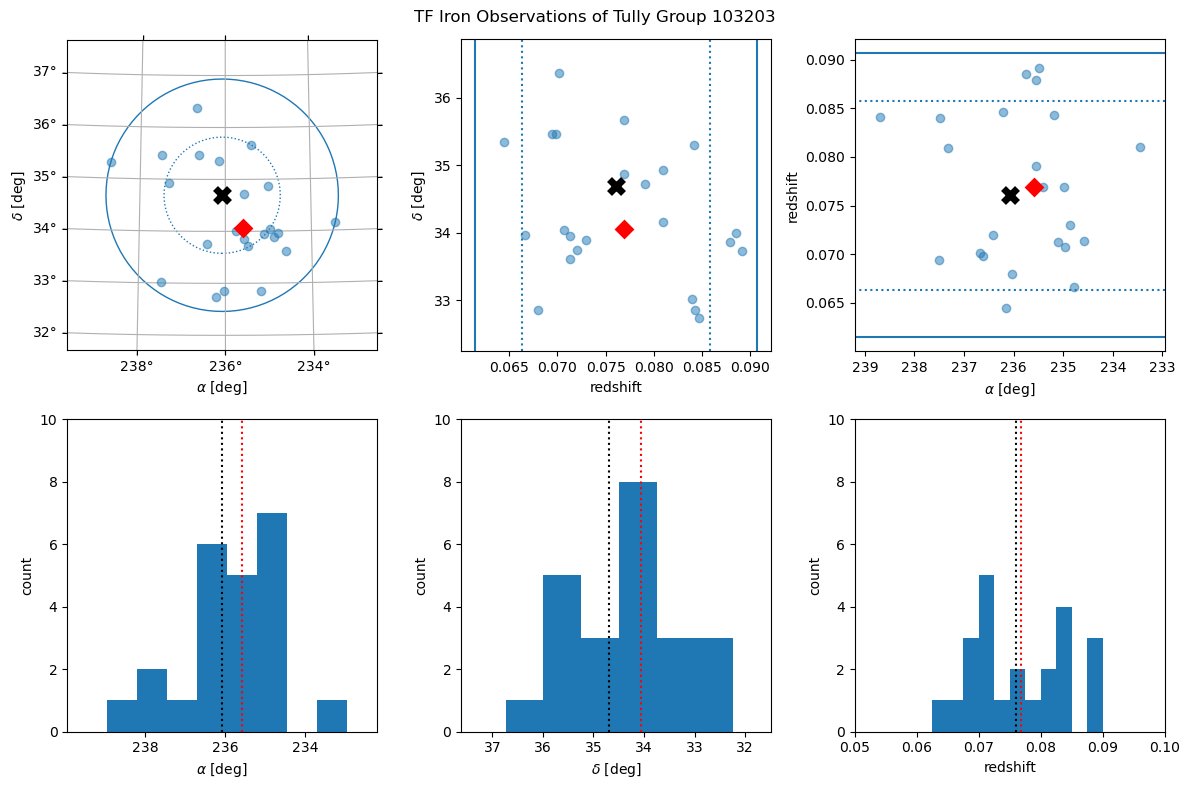

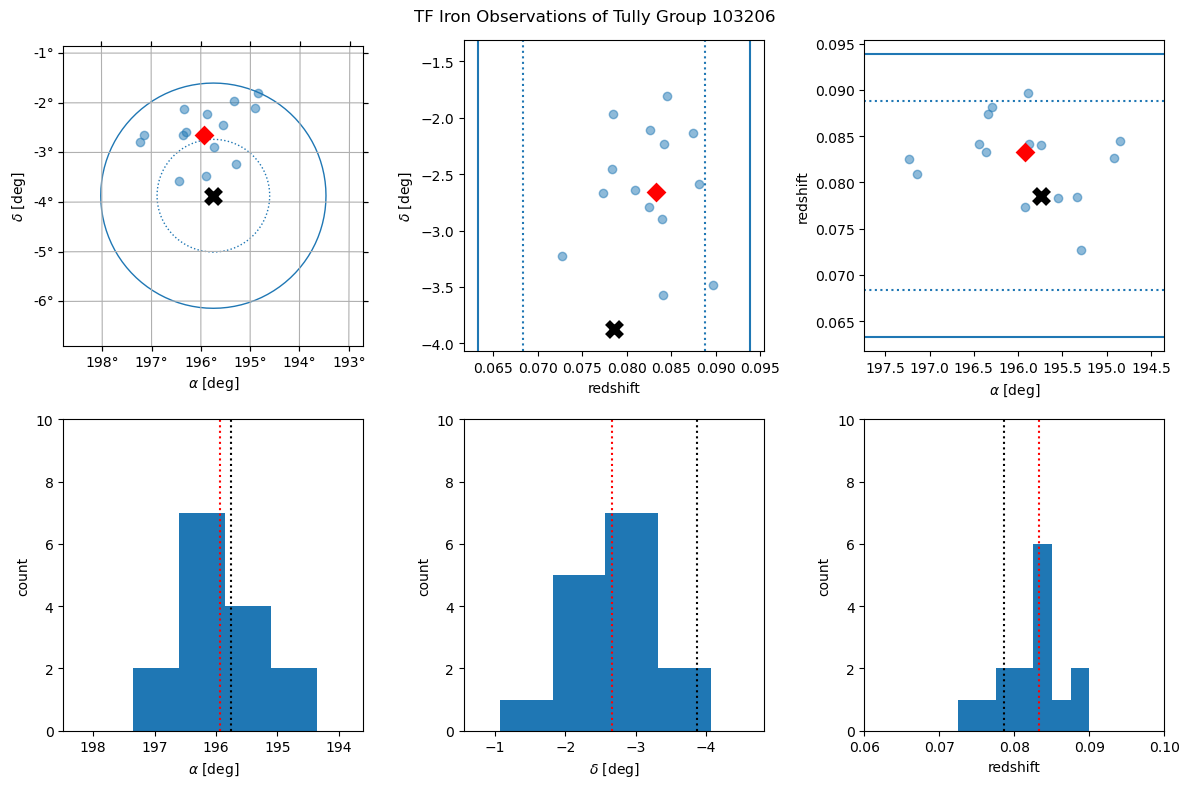

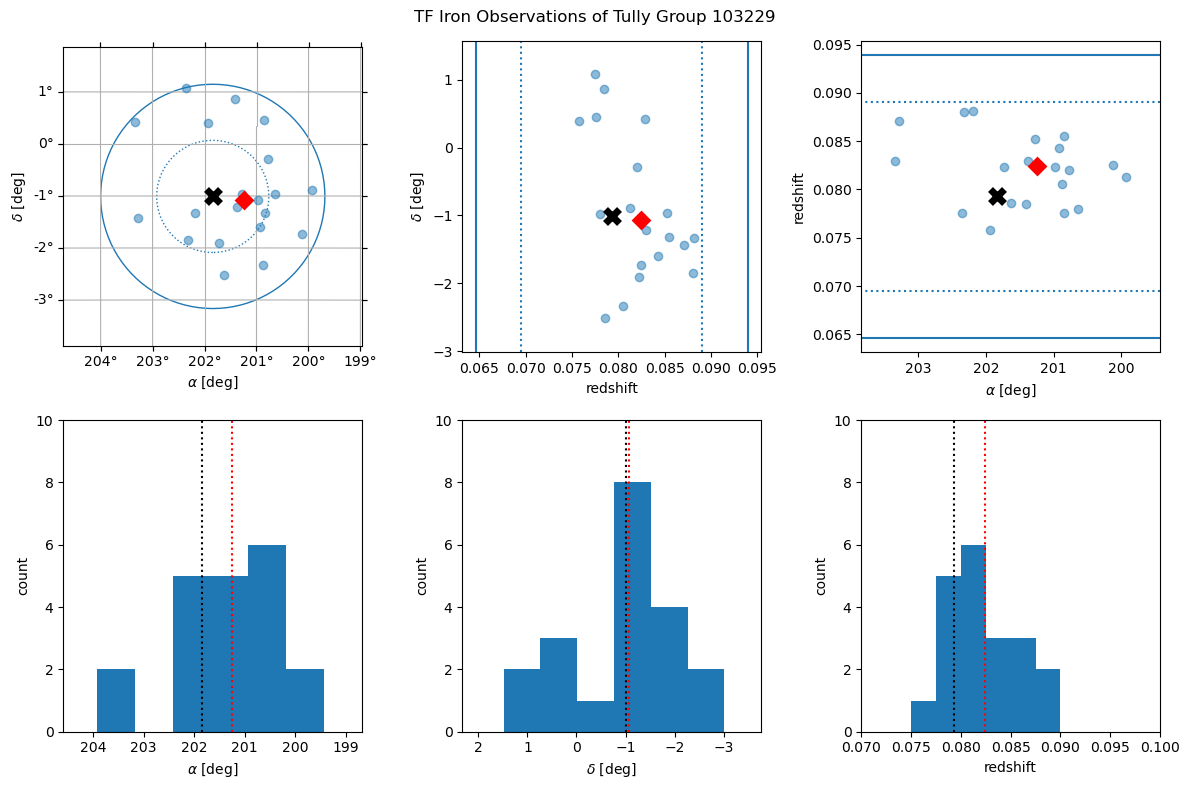

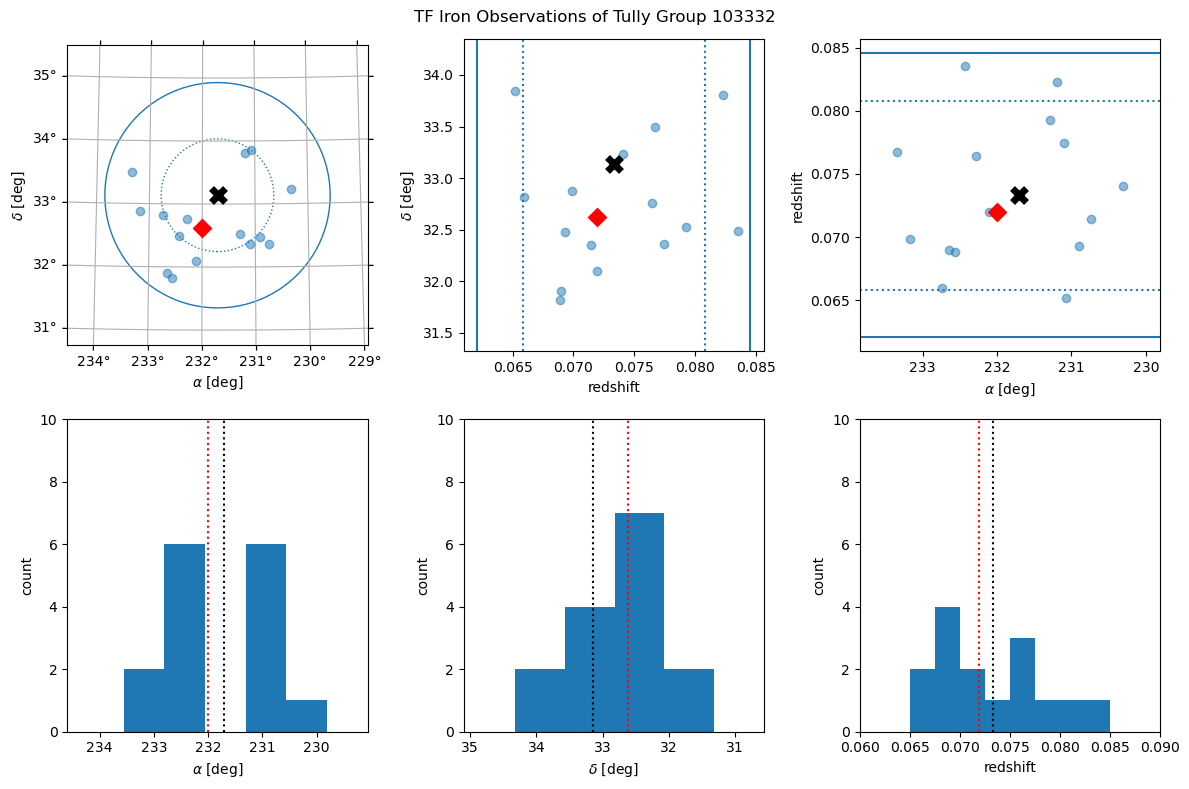

In [25]:
for cluster_id in sga_clusters.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])

## Apply Cluster Selection

Plot the clusters as a function of $\Delta\theta/\angle(R_{2t})$ versus $Delta v/\sigma_P$. The quantities are:
* $\Delta\theta$: the angular separation between the median position of the DESI observations and the cluster center reported in Tully 2015.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster, reported in Tully 2015.

A reasonable selection appears to be

1. $\Delta v/ \sigma_P < 1$
2. $\Delta\theta / R_{2t} < 1$

100002       196.112 km/s     707.000 km/s       0.277      11.154 deg       5.510 deg       1.350
100007       521.485 km/s    1385.000 km/s       0.377       1.155 deg       1.395 deg       0.552
100042       168.234 km/s     545.000 km/s       0.309       0.523 deg       0.753 deg       0.463
100046       662.797 km/s     714.000 km/s       0.928       0.606 deg       0.764 deg       0.529
100058       943.391 km/s     781.000 km/s       1.208       0.059 deg       0.721 deg       0.055
100067       223.131 km/s     954.000 km/s       0.234       0.496 deg       0.961 deg       0.344
100077        76.658 km/s    1914.000 km/s       0.040       0.537 deg       1.222 deg       0.293
100081        88.183 km/s     635.000 km/s       0.139       0.148 deg       0.664 deg       0.149
100282       229.590 km/s    2071.000 km/s       0.111       1.879 deg       1.156 deg       1.084
101400       754.588 km/s    1711.000 km/s       0.441       0.401 deg       0.892 deg       0.300
101434    

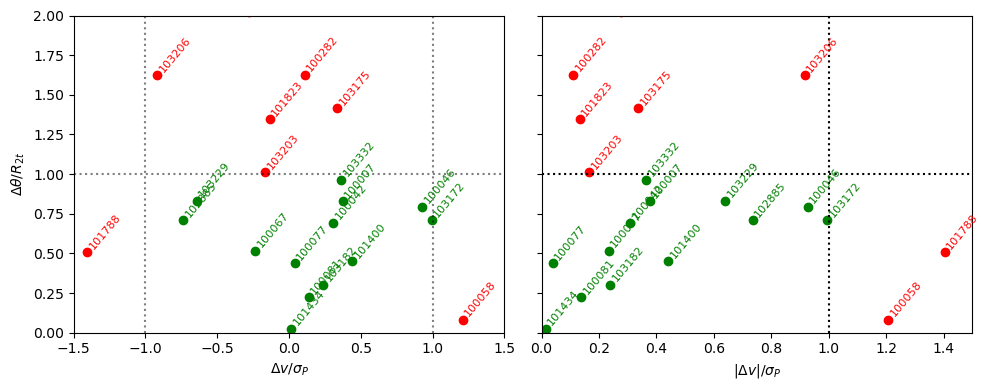

In [26]:
keep_cluster = []
dv_sigmaP = []
dtheta_R2t = []
cluster_ids = []

for cluster_id, sga_ids in sga_clusters.items():
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')
    
    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgatab['SGA_ID'], sga_ids)
    z_sga = sgatab['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Compute the angle and velocity ratios:
    delta_v = cluster_v - c_kms*z_sga_median
    _dv_sigP = delta_v / cluster_sigma
    dv_sigmaP.append(_dv_sigP)

    delta_theta = sga_coords_median.separation(cluster_coord).to('rad')
    _dth_R2t = delta_theta / cluster_R2t_angle
    dtheta_R2t.append(_dth_R2t)

    cluster_ids.append(cluster_id)

    #- Print results:
    print(f'{cluster_id:<8d}{np.abs(delta_v):12.3f} km/s{cluster_sigma:12.3f} km/s{np.abs(delta_v)/cluster_sigma:12.3f}' \
          f'{delta_theta.to("deg"):12.3f}{cluster_R2t_angle.to("deg"):12.3f}{delta_theta / (1.5*cluster_R2t_angle):12.3f}')

dv_sigmaP = np.asarray(dv_sigmaP)
dtheta_R2t = np.asarray(dtheta_R2t)
cluster_ids = np.asarray(cluster_ids)

#- Apply selection
dvcut = 1
dthcut = 1
select = (np.abs(dv_sigmaP) < dvcut) & (dtheta_R2t < dthcut)

#- Plot results

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
ax = axes[0]
ax.scatter(dv_sigmaP[select], dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(dv_sigmaP[select], dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(dv_sigmaP[~select], dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(dv_sigmaP[~select], dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
ax.set(xlabel=r'$\Delta v/\sigma_P$',
       xlim=(-1.5, 1.5),
       ylabel=r'$\Delta\theta/R_{2t}$',
       ylim=(0,2))

ax = axes[1]
ax.scatter(np.abs(dv_sigmaP[select]), dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[select]), dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k')
ax.axvline(-dvcut, ls=':', color='k')
ax.axhline(dthcut, ls=':', color='k')
ax.set(xlabel=r'$|\Delta v|/\sigma_P$',
       xlim=(0, 1.5));

# fig.savefig('TF_Y1_SGA_Vrot_clusters_selection.png', dpi=150);

In [27]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

 1  100002  17 galaxies  N
 2  100007  21 galaxies  Y
 3  100042  19 galaxies  Y
 4  100046  16 galaxies  Y
 5  100058  23 galaxies  N
 6  100067  32 galaxies  Y
 7  100077  16 galaxies  Y
 8  100081  15 galaxies  Y
 9  100282  26 galaxies  N
10  101400  26 galaxies  Y
11  101434  19 galaxies  Y
12  101788  24 galaxies  N
13  101823  15 galaxies  N
14  102885  18 galaxies  Y
15  103172  17 galaxies  Y
16  103175  19 galaxies  N
17  103182  30 galaxies  Y
18  103203  23 galaxies  N
19  103206  15 galaxies  N
20  103229  20 galaxies  Y
21  103332  15 galaxies  Y


#### Plot Galaxy Clusters that Failed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
1492.7944095789974 +/- 707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.76646719, 1.62439612)>
12647.363474711521 +/- 781 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 2071 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.7953898, 0.67439744)>
21877.616239495565 +/- 1599 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (159.82603928, 4.85617483)>
21978.598727848275 +/- 1636 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.99936671, 31.21107645)>
23550.492838960086 +/- 1707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (236.07424061, 34.69623742)>
22803.420720004207 +/- 1458 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.74616921, -3.87530193)>
23550.492838960086 +/- 1529 km/s


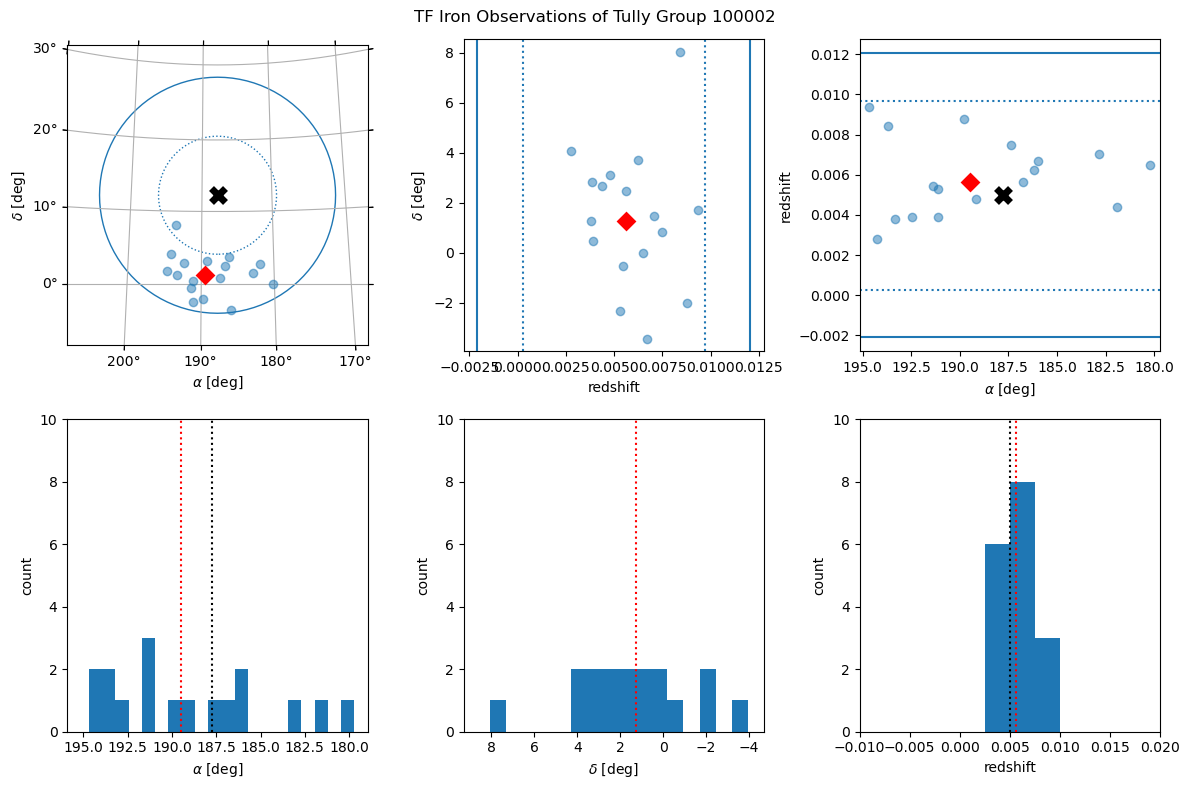

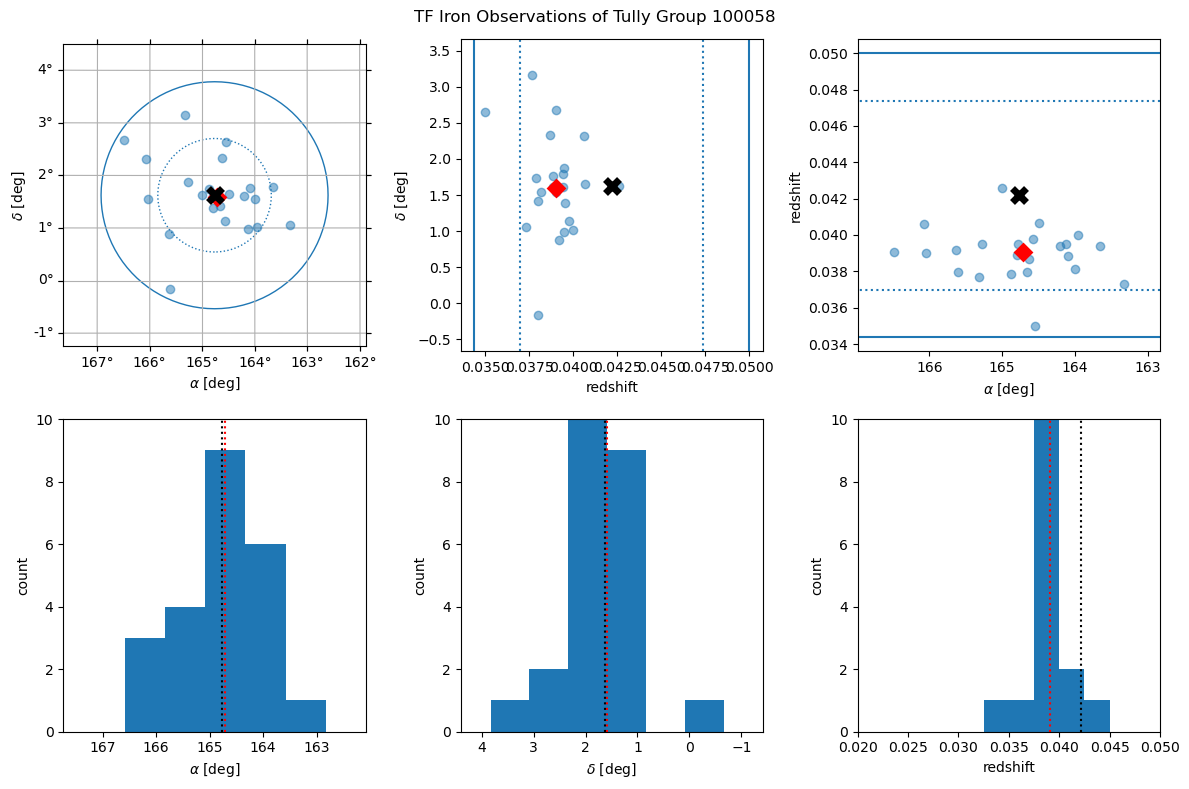

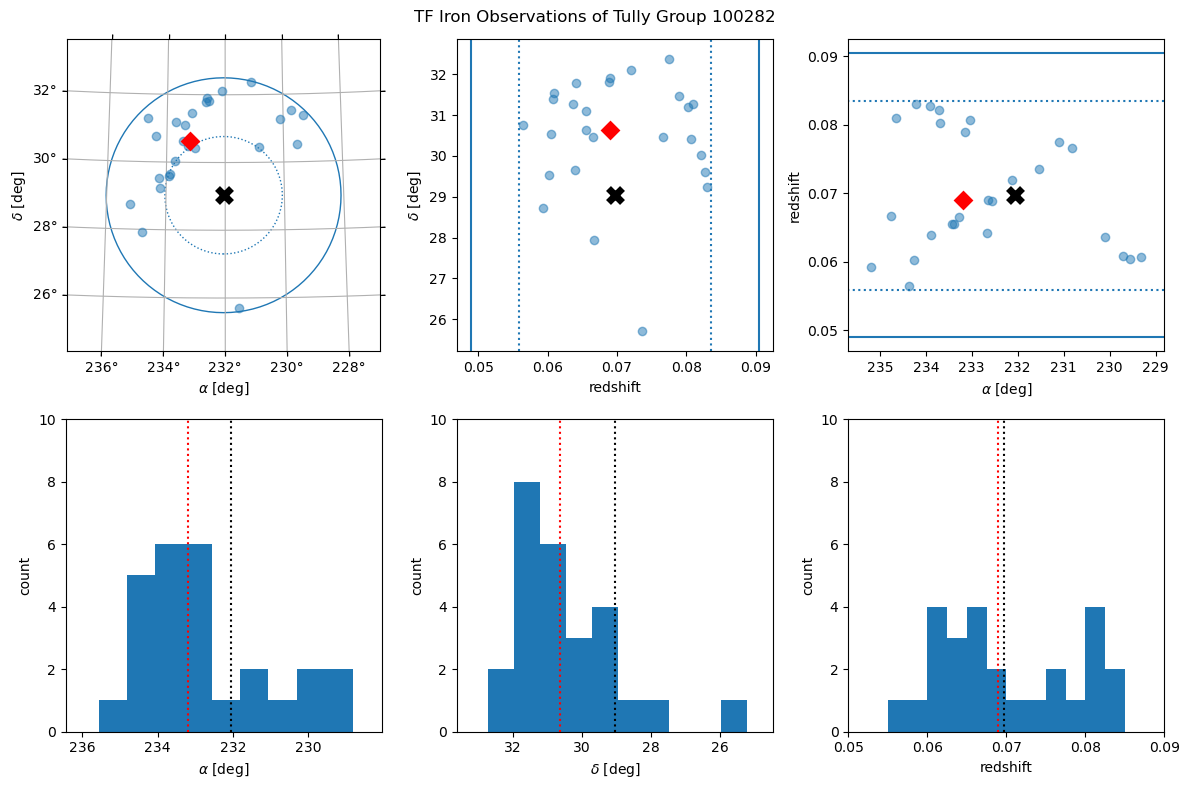

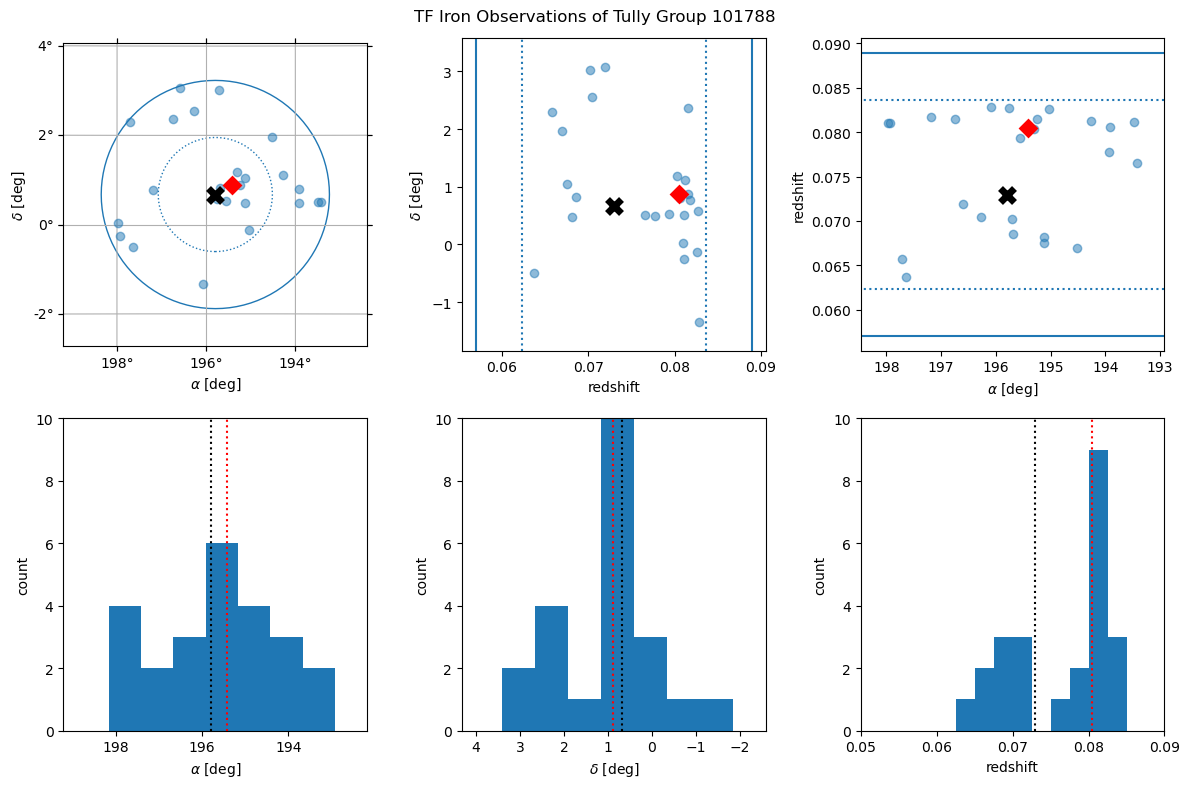

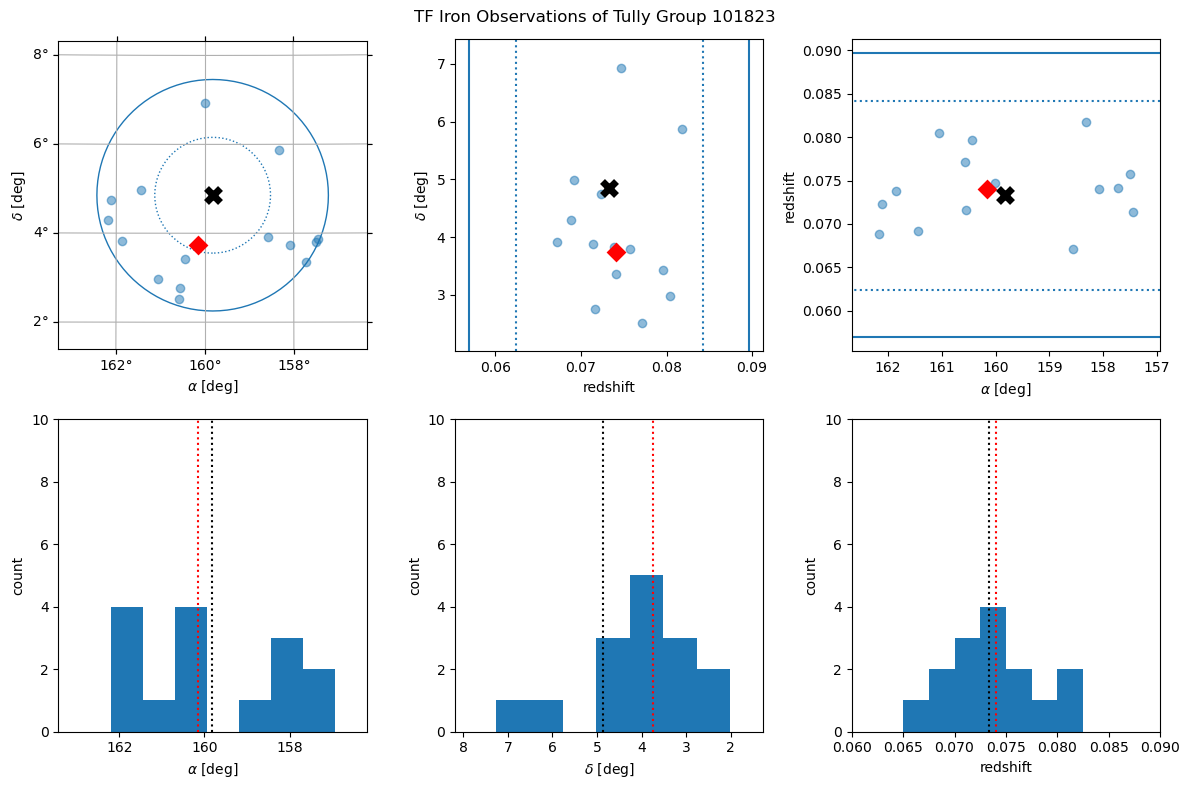

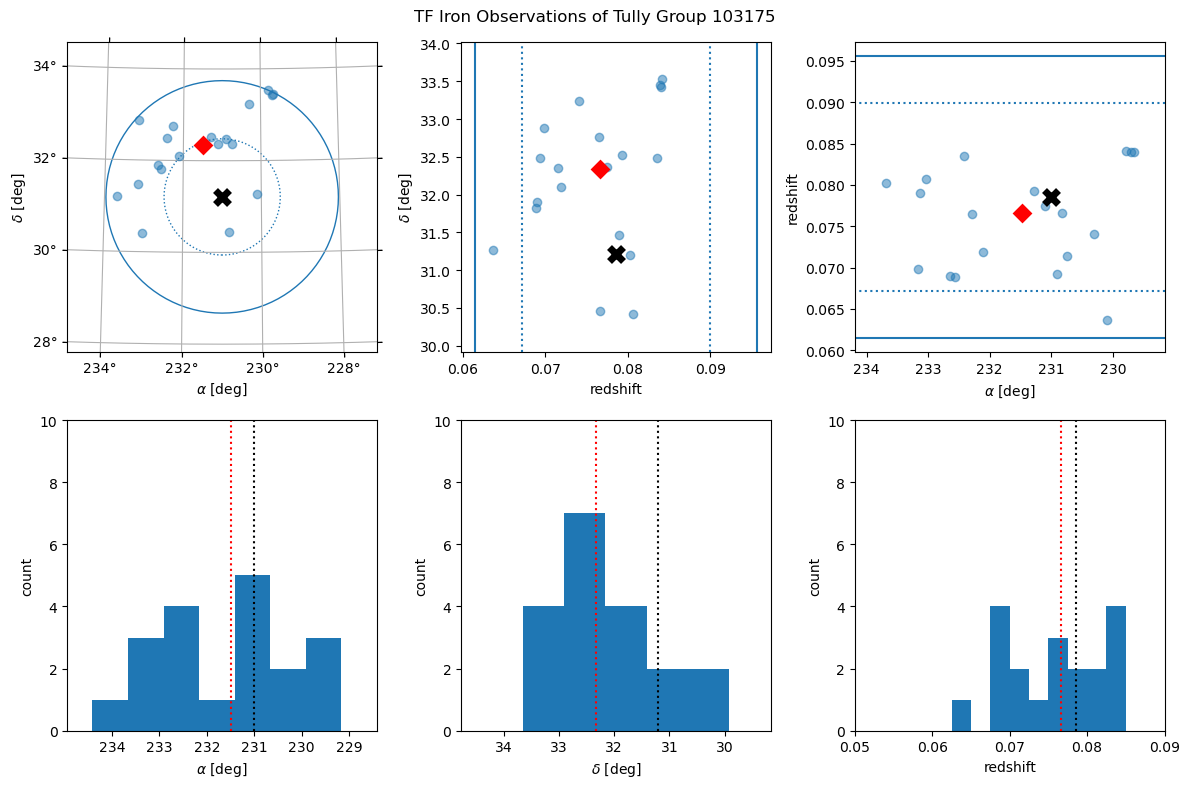

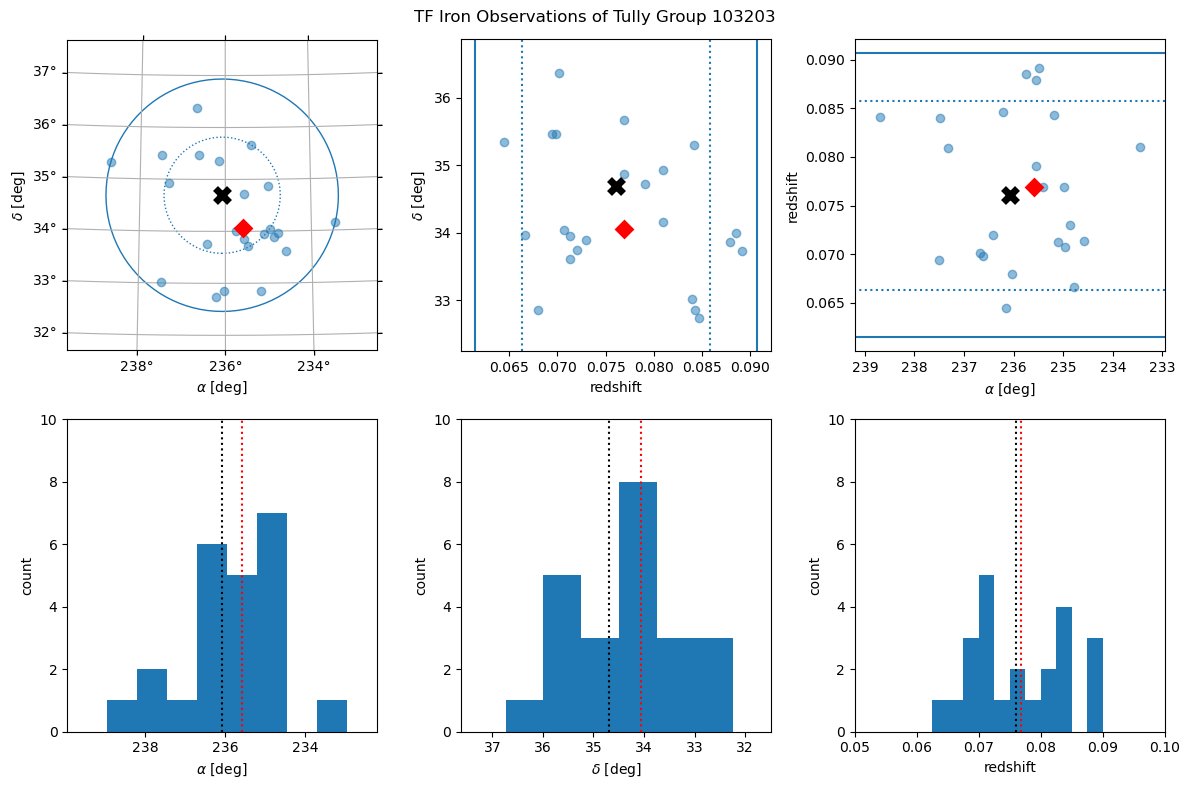

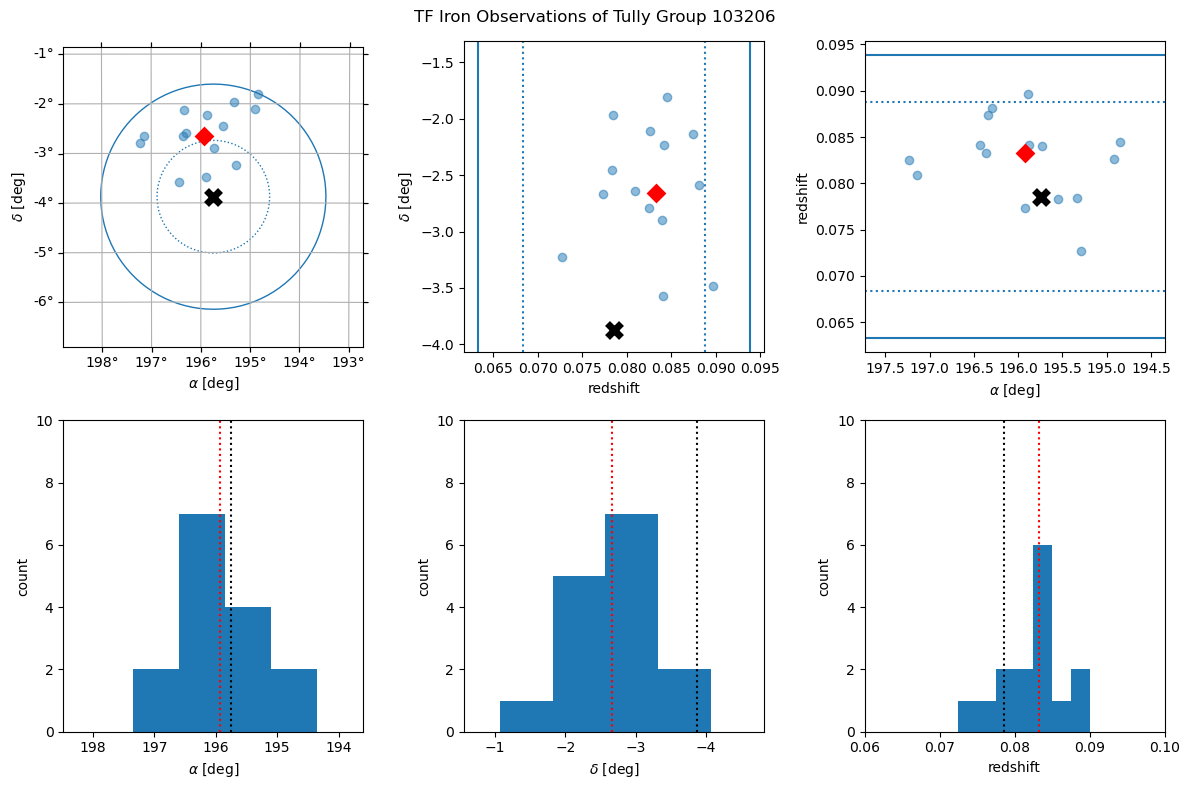

In [28]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[~select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_reject.png', dpi=150);

#### Plot Galaxy Clusters that Passed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (220.13676059, 3.3706831)>
8433.347577642775 +/- 545 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (197.68010565, 34.27637749)>
11168.632477805635 +/- 635 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (160.81499432, 1.91346557)>
22387.211385683422 +/- 1711 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (233.44768796, 33.24483532)>
20701.413487910413 +/- 1196 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (227.0389939, -0.84791796)>
22803.420720004207 +/- 1973 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (237.23262377, 8.84560326)>
23014.418174085138 +/- 1823 km/s
<S

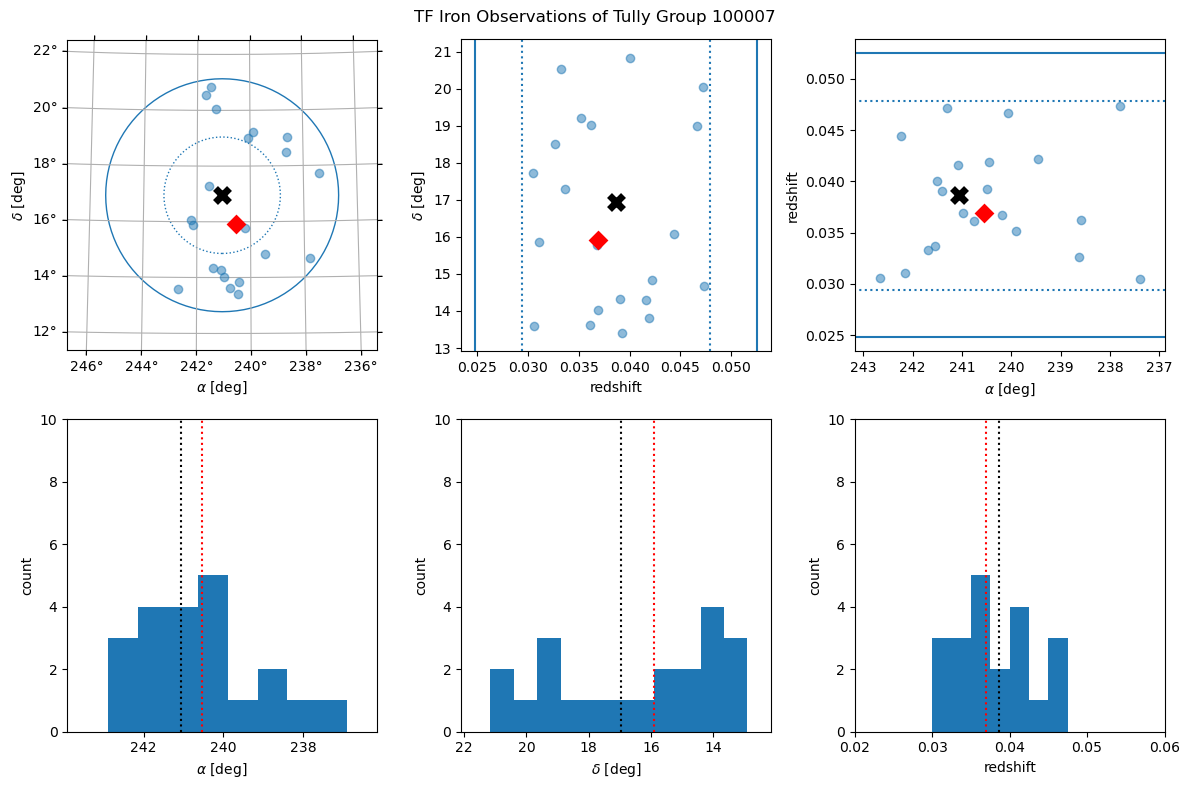

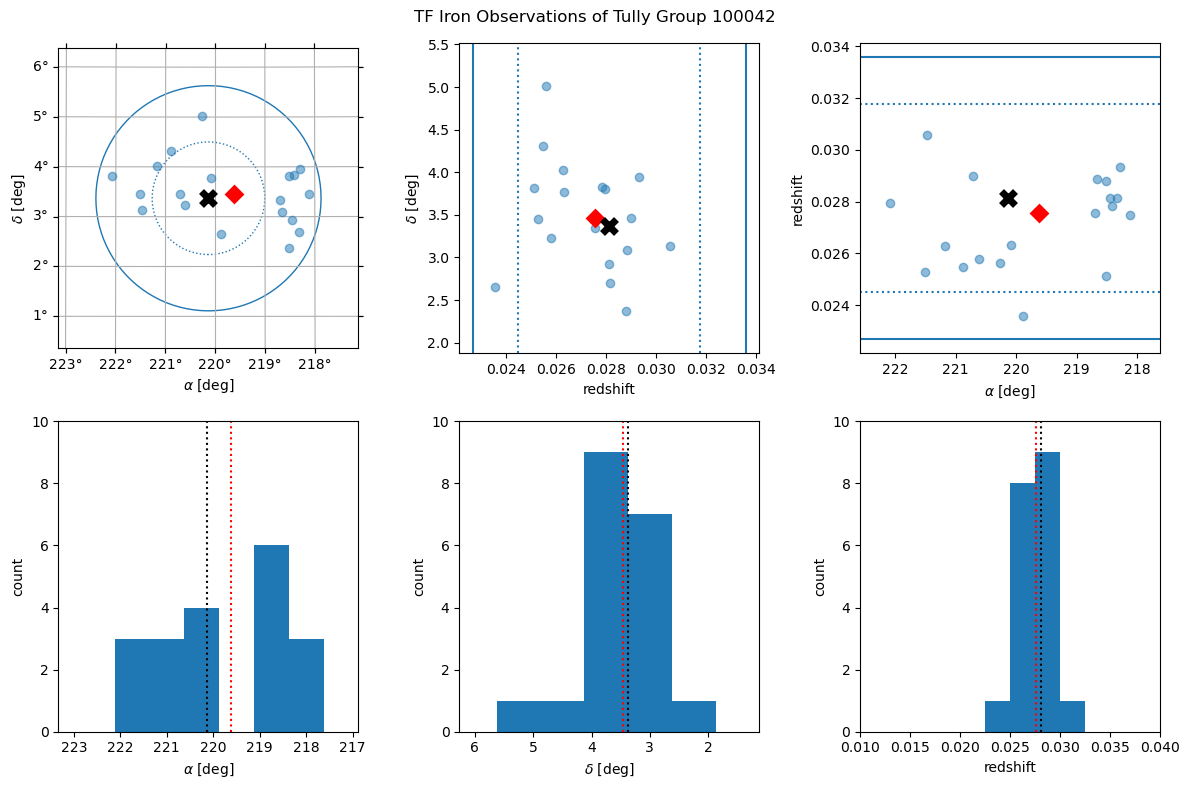

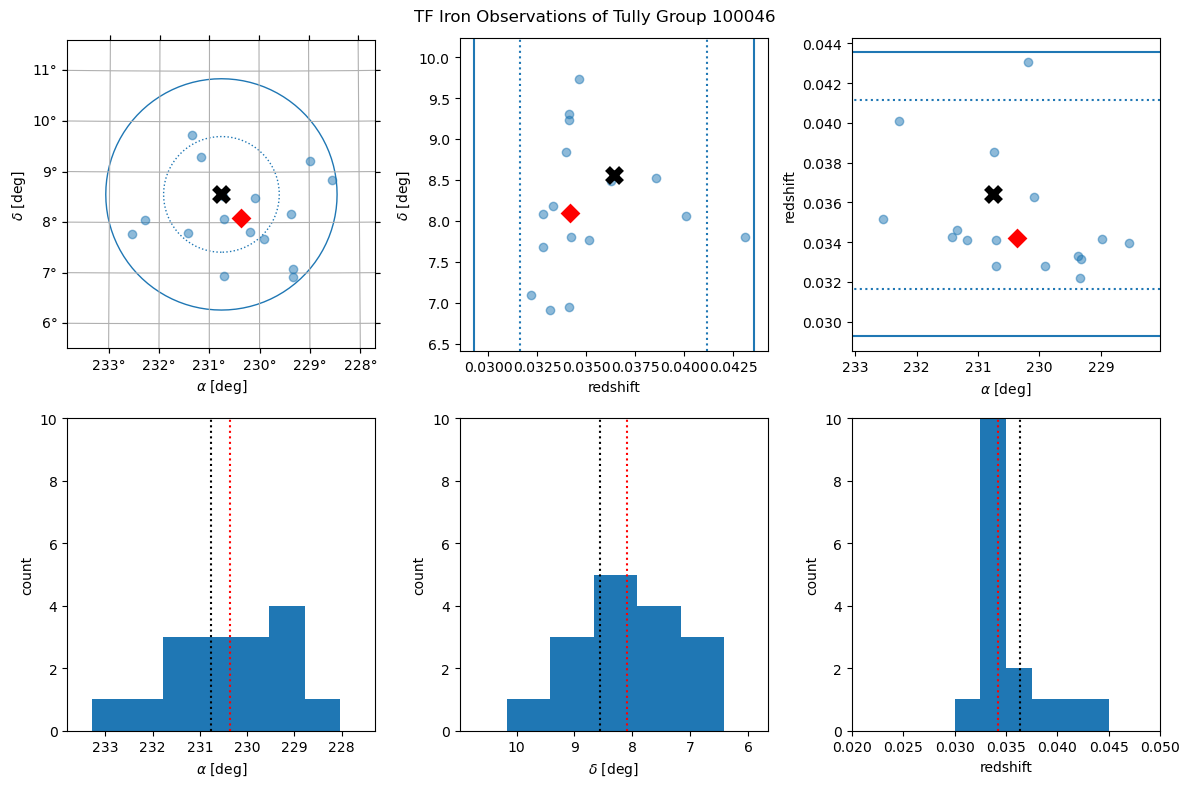

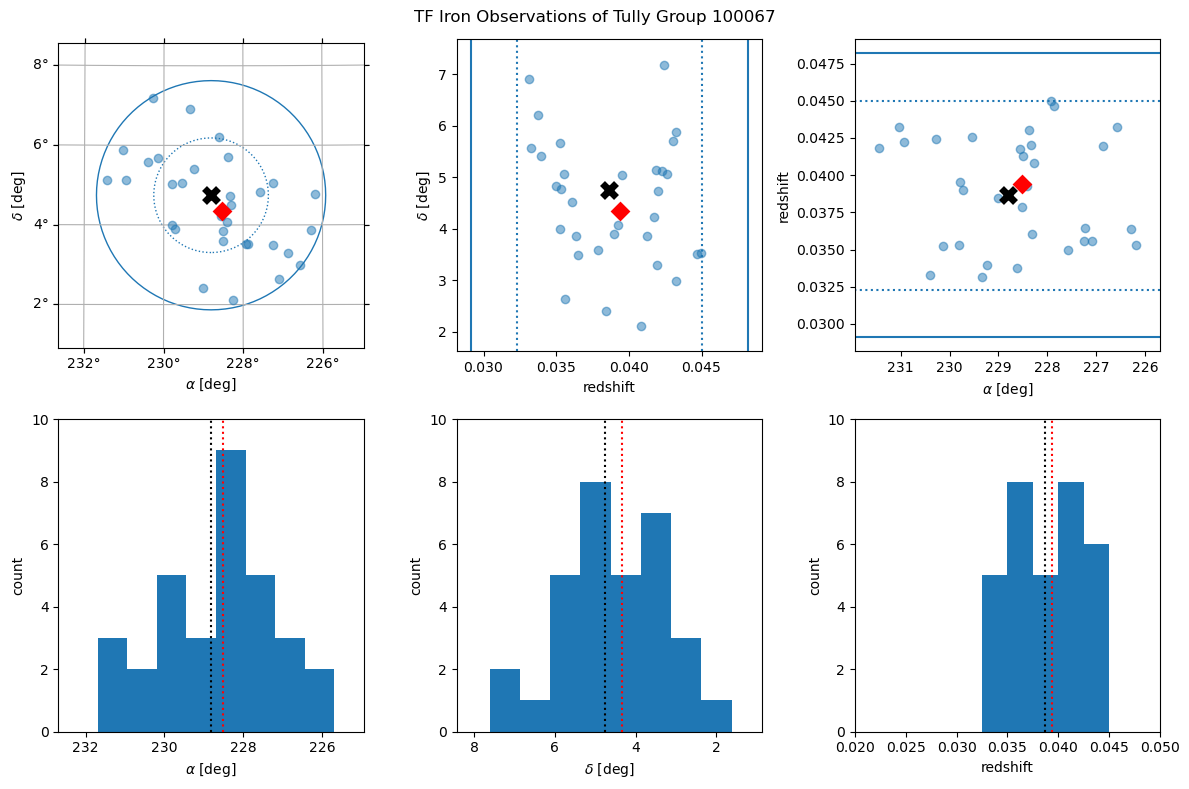

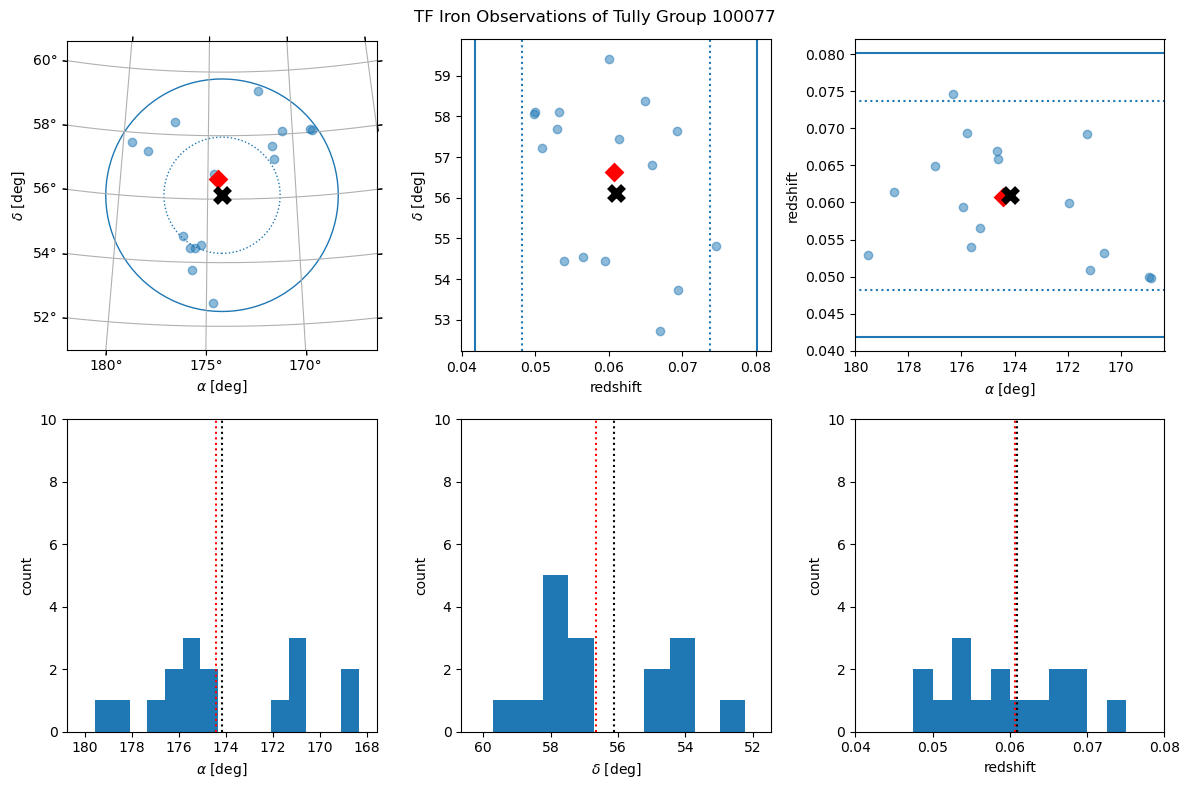

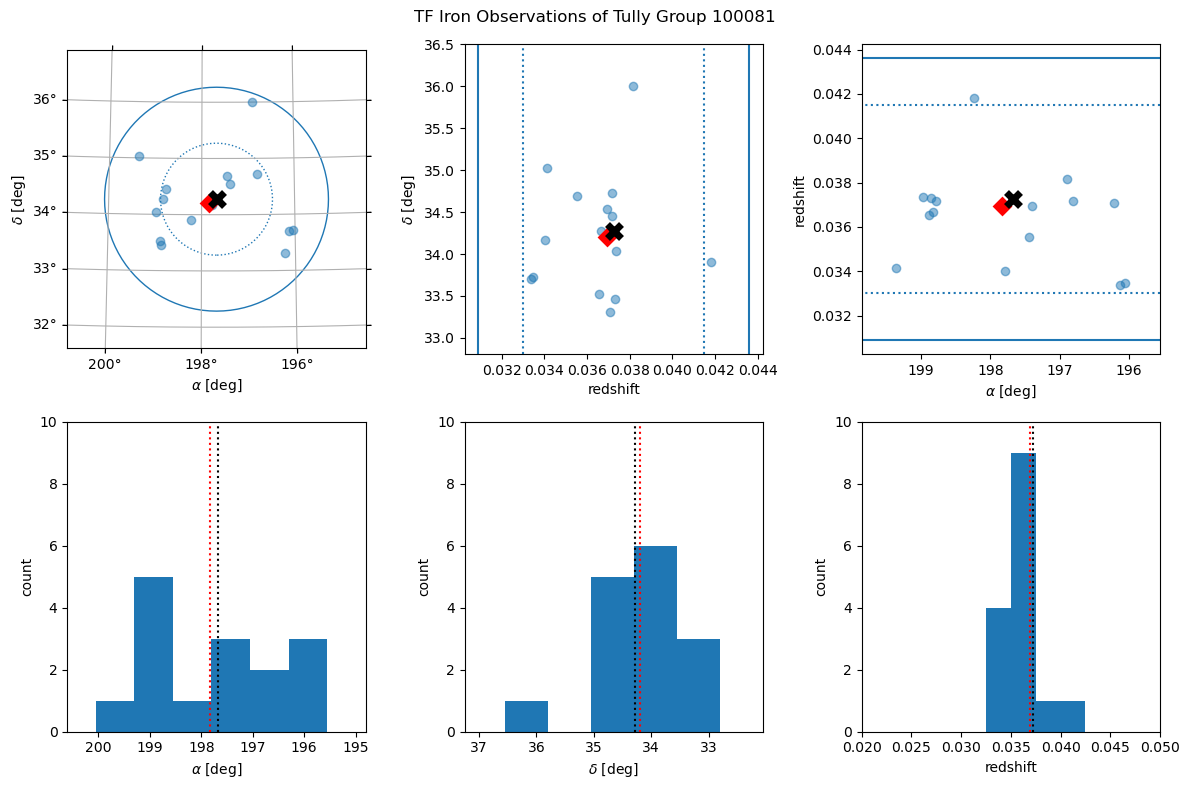

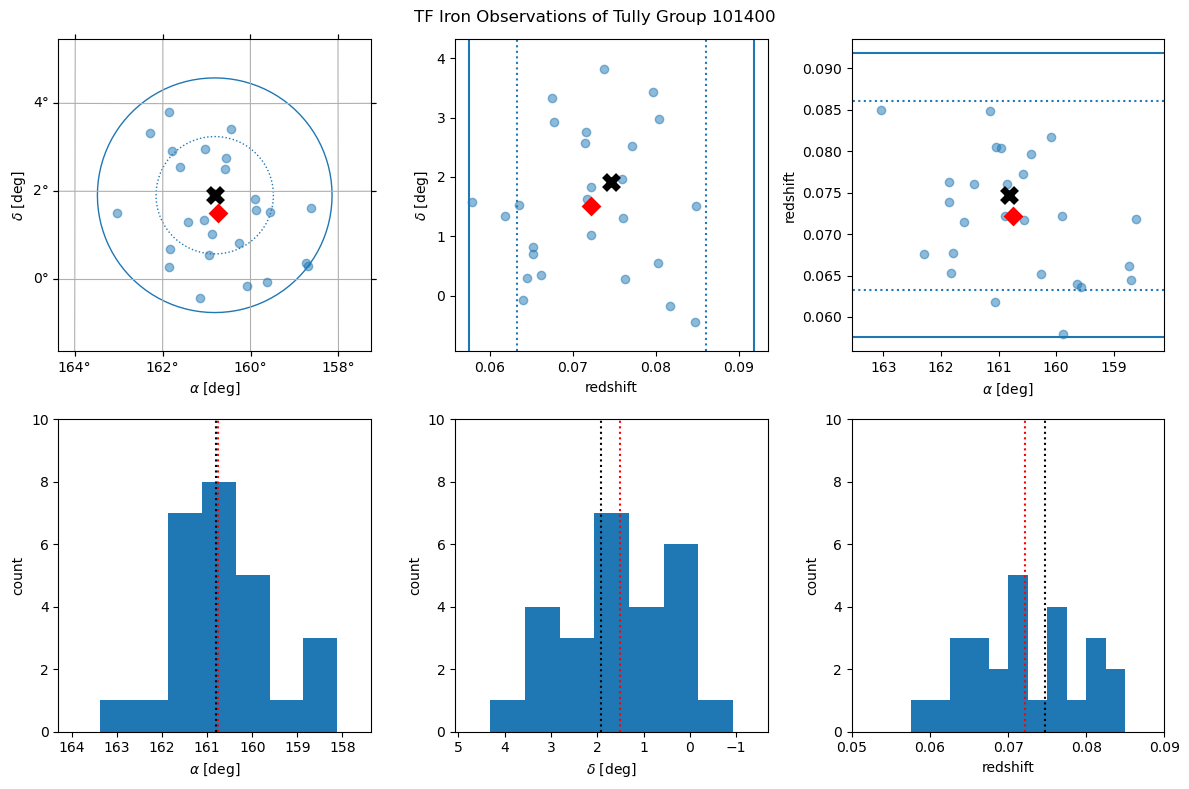

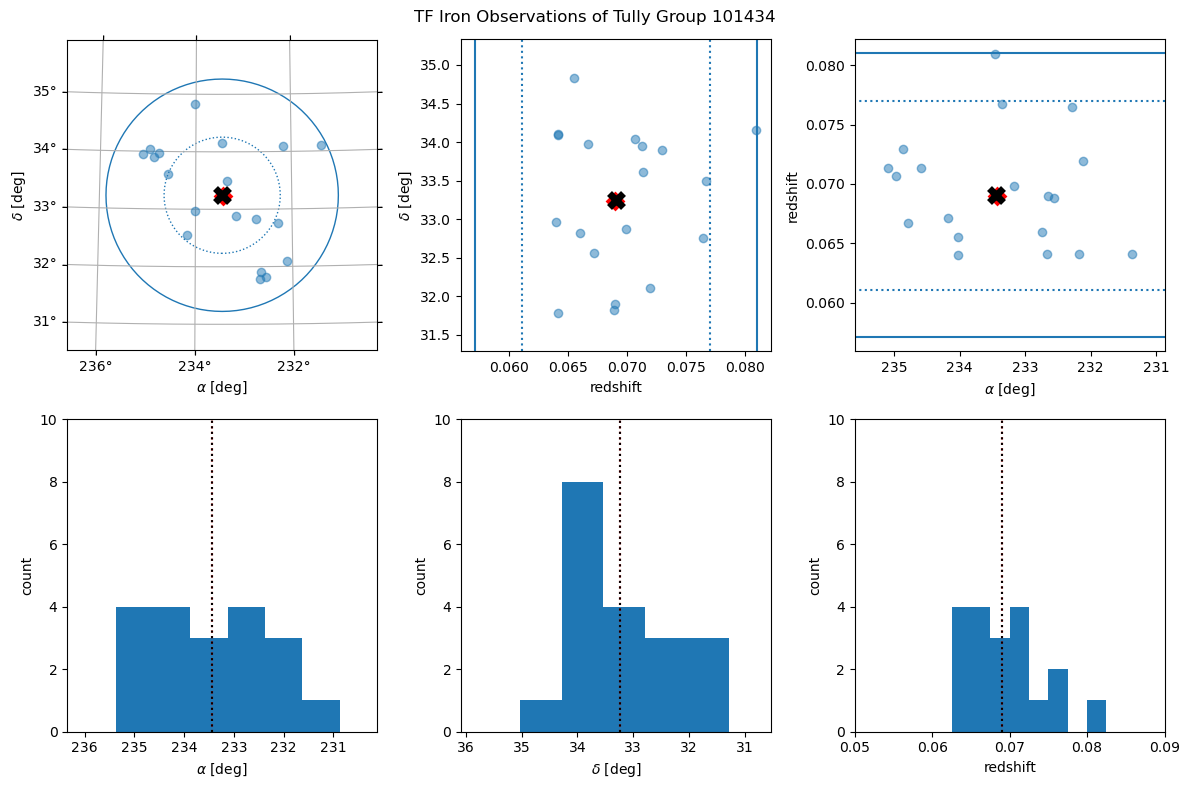

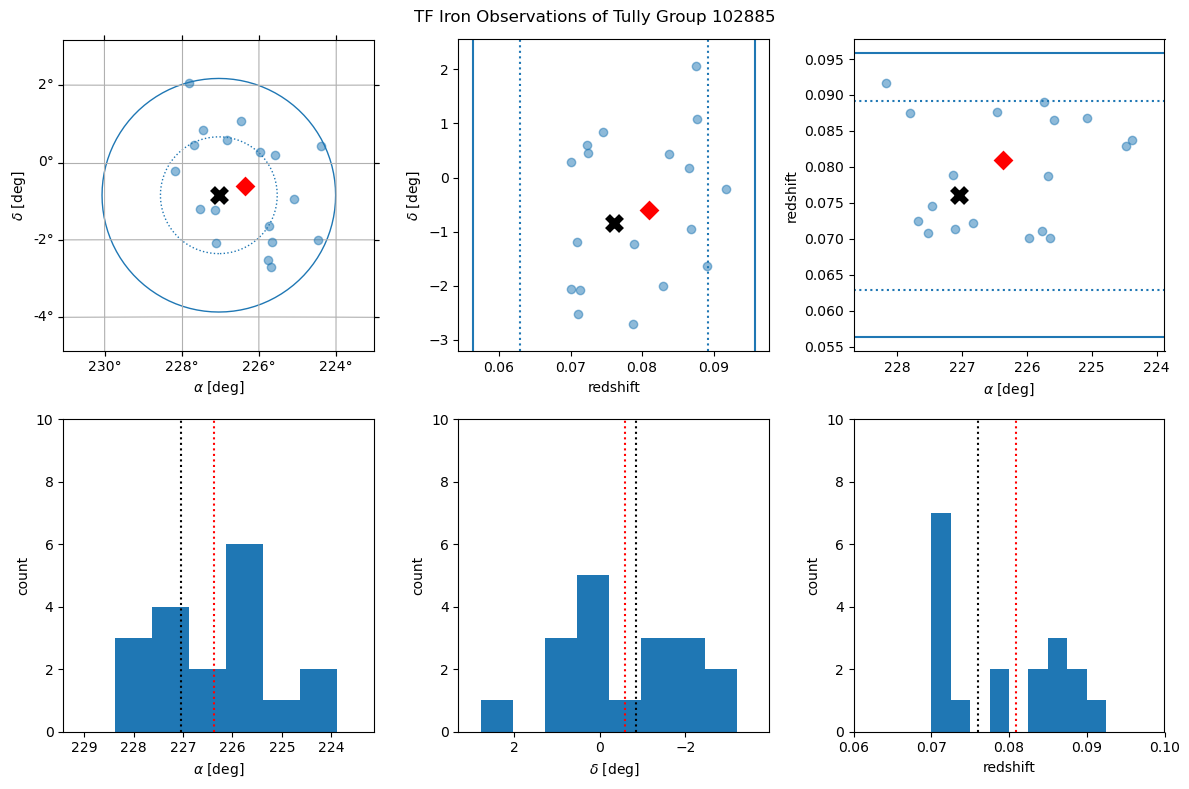

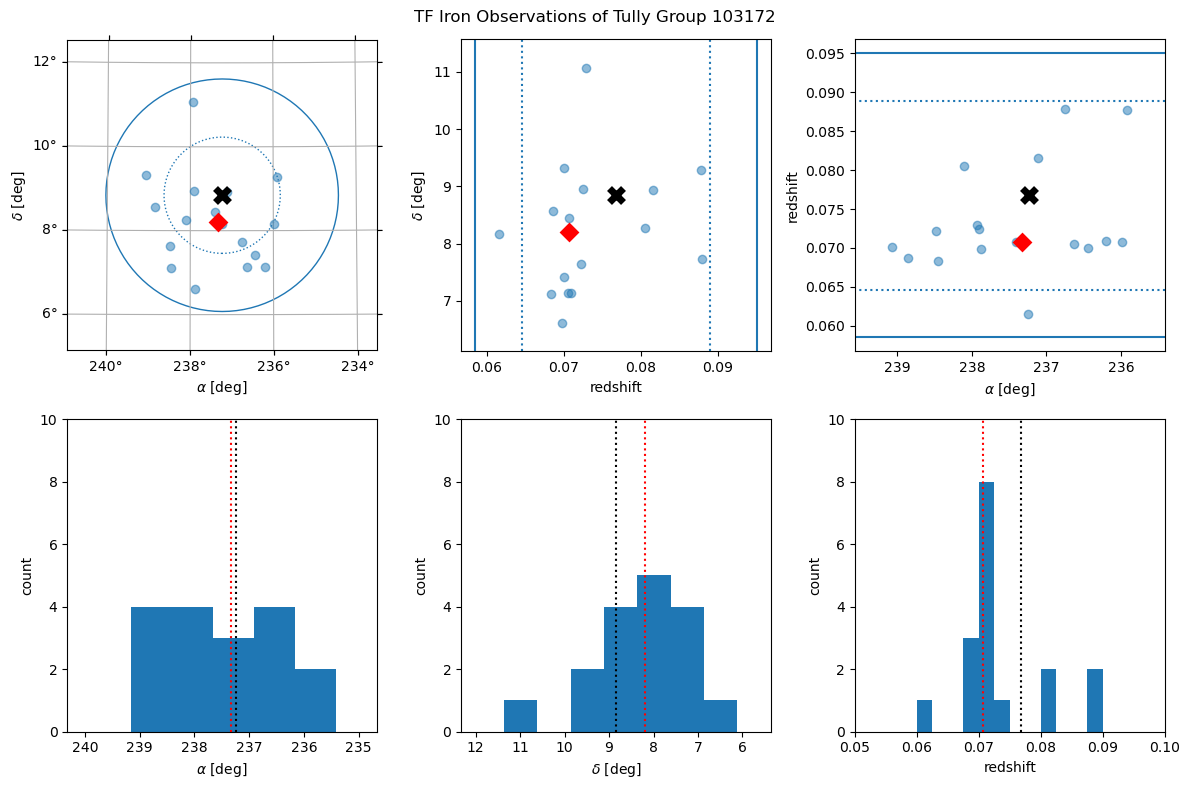

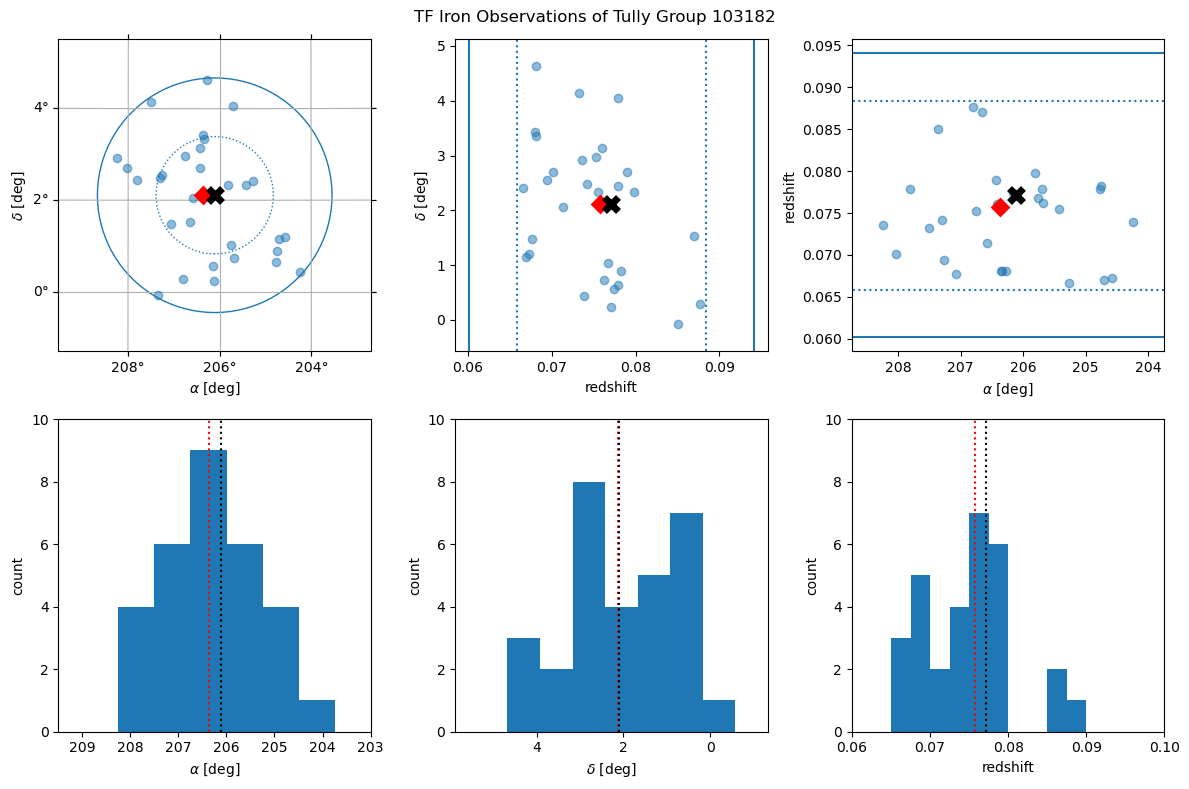

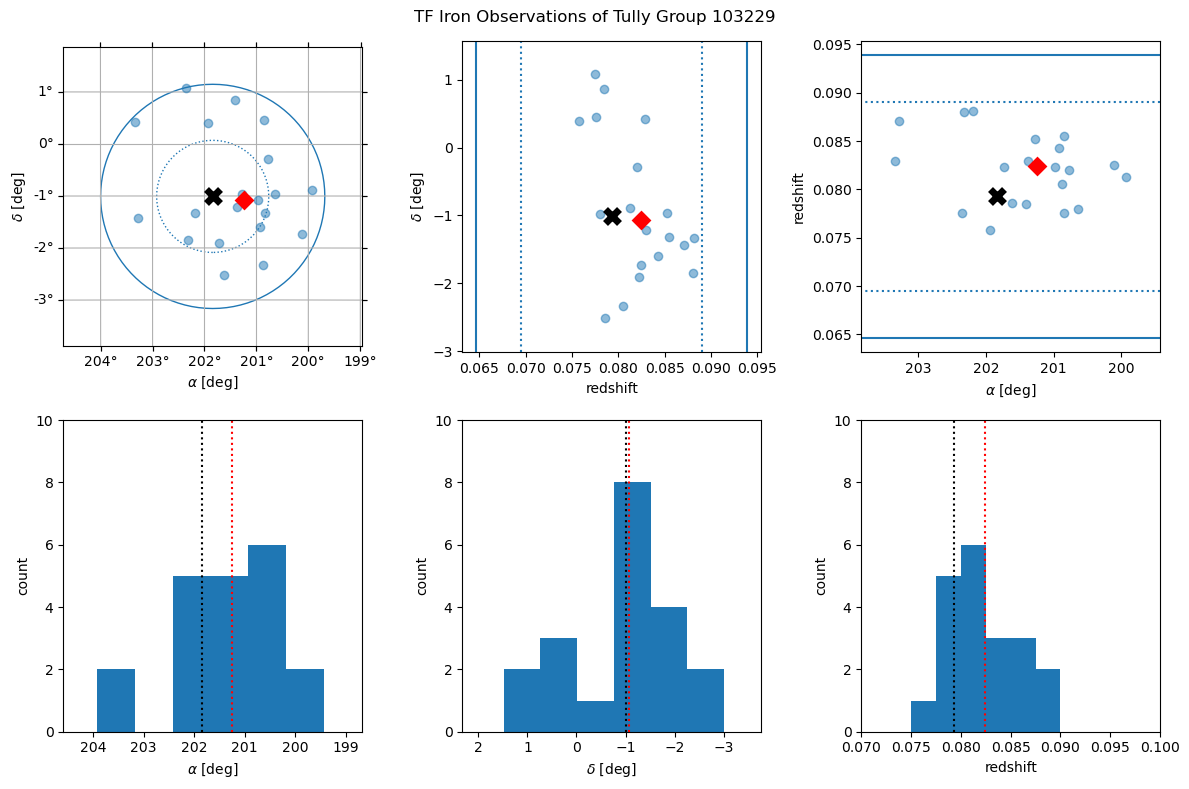

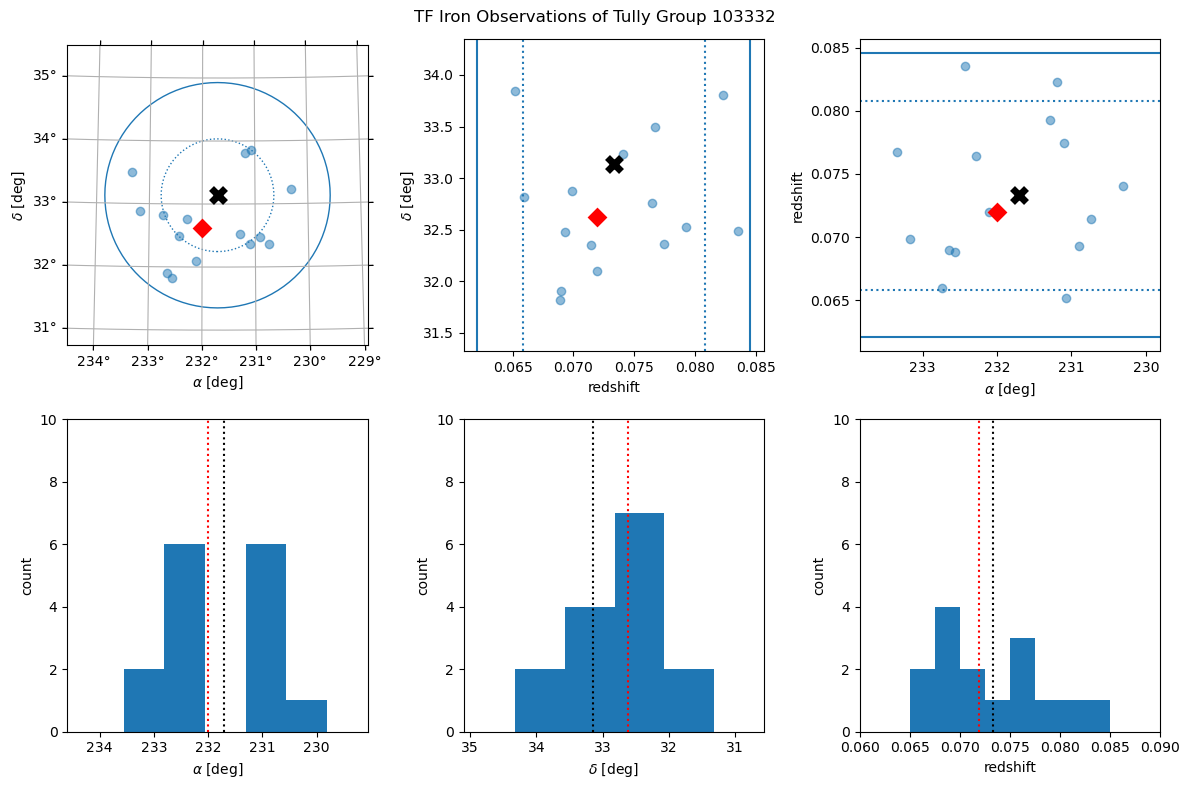

In [29]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_accept.png', dpi=150);

## Build the Calibration Table of SGA Galaxies in Clusters

In [30]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for cluster_id, sga_ids in sga_clusters.items():
    if cluster_id in cluster_ids[select]:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        caltab = clustertab if caltab is None else vstack([caltab, clustertab])
    else:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

caltab.write('SGA-2020_iron_Vrot_cluster_calib.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'V_0p4R26', 'V_0p4R26_err']]

<Table length=264>
CLUSTER_ID  SGA_ID R_MAG_SB26 ...      V_0p4R26         V_0p4R26_err   
  int32     int64   float32   ...      float64            float64      
---------- ------- ---------- ... ------------------ ------------------
    100007   33321   15.56614 ...  163.2164033717864  2.070863659772805
    100007  199506  16.979681 ... 112.24001108666938  6.451112957145022
    100007  281765  15.341095 ...  91.94105314972285 29.914576074436184
    100007  295688    16.0277 ... 170.63766996868208 1.9564003639895968
    100007  364205  16.224758 ... 171.61073093905517 6.0912392170049205
    100007  378878  16.529648 ...  84.56206608532045 1.5261698250909974
    100007  447873  15.450913 ... 147.17674021468054 0.9837357860152643
    100007  472833  16.271893 ...  91.17498544274386  4.479662707259152
    100007  485824  17.510582 ...   68.5767468775605 3.0460724144715887
    100007  547663  15.313065 ... 155.64437655332708 1.8621150791542374
       ...     ...        ... ...                ...                ...
    103332  283533  16.320572 ... 187.34020903694278  2.254920259922843
    103332  643563  15.617497 ...  266.5851401214524 3.6256814190838043
    103332  647902  15.829676 ... 220.59259318179792 2.0247650815788423
    103332  669030  16.751162 ... 159.42444459299577 3.5902624737648132
    103332  914350  15.957561 ... 201.63725239243817  9.628996158285045
    103332  991476   16.23689 ...  257.6051616207889  8.451971155555583
    103332 1004334  16.339346 ... 173.46172848209582  2.770738131750259
    103332 1079120  17.212542 ... 156.85159873352043 3.9497297931195474
    103332 1104181  17.397501 ...  159.1390981400865  4.438605156721428
    103332 1281504   16.45048 ... 203.75598599142887 16.903842479906835

In [31]:
rejtab

<Table length=162>
 SGA_ID    SGA_GALAXY      GALAXY   ... MORPHTYPE_AI CLUSTER_ID
 int64      bytes16       bytes29   ...    str10       int32   
------- ---------------- ---------- ... ------------ ----------
 117242  SGA-2020 117242    NGC4348 ...       Spiral     100002
 149009  SGA-2020 149009   UGC06998 ...    Irregular     100002
 156492  SGA-2020 156492   UGC07911 ...   Undecided      100002
 200990  SGA-2020 200990  PGC044215 ...   Undecided      100002
 246089  SGA-2020 246089  PGC044474 ...   Undecided      100002
 254532  SGA-2020 254532    NGC4409 ...       Spiral     100002
 516235  SGA-2020 516235   UGC07982 ...    Irregular     100002
 638386  SGA-2020 638386   UGC07184 ...   Undecided      100002
 698806  SGA-2020 698806  PGC040414 ...       Spiral     100002
 887433  SGA-2020 887433    NGC4771 ...       Spiral     100002
    ...              ...        ... ...          ...        ...
 813170  SGA-2020 813170 PGC1105184 ...       Spiral     103206
 814280  SGA-2020 814280 PGC1074367 ...       Spiral     103206
 903127  SGA-2020 903127 PGC1101463 ...       Spiral     103206
 992732  SGA-2020 992732 PGC1097938 ...       Spiral     103206
1079853 SGA-2020 1079853 PGC1069545 ...       Spiral     103206
1172502 SGA-2020 1172502 PGC1091637 ...       Spiral     103206
1181551 SGA-2020 1181551 PGC1082776 ...       Spiral     103206
1261296 SGA-2020 1261296 PGC1086377 ...   Undecided      103206
1265122 SGA-2020 1265122 PGC1080425 ...       Spiral     103206
1398191 SGA-2020 1398191 PGC1085739 ...   Undecided      103206

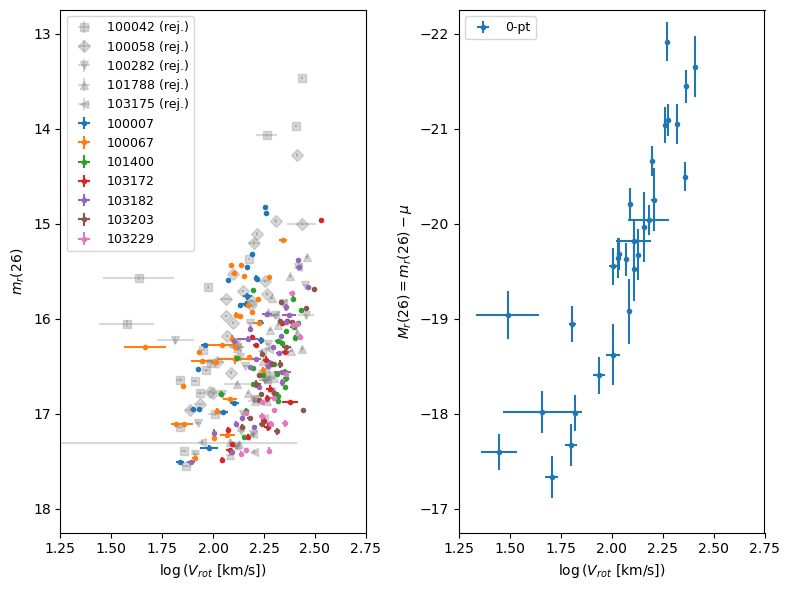

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#- Plot galaxies with failed cluster selections.
_cluster_ids = np.unique(rejtab['CLUSTER_ID'])
markers = 'sDv^<>'
for j, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26'][select_cluster].data
    mr26_err = rejtab['R_MAG_SB26_ERR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[18.25, 12.75],
       ylabel=r'$m_r (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-16.75, -22.25],
       ylabel=r'$M_r(26) = m_r(26) - \mu$')
ax.legend(loc='upper left', fontsize=9)

fig.savefig('TF_Y1_cluster_calibration_0pt.png', dpi=150)

#### Plot a Chi-by-Eye fit to Guess at the Right Slope, V0

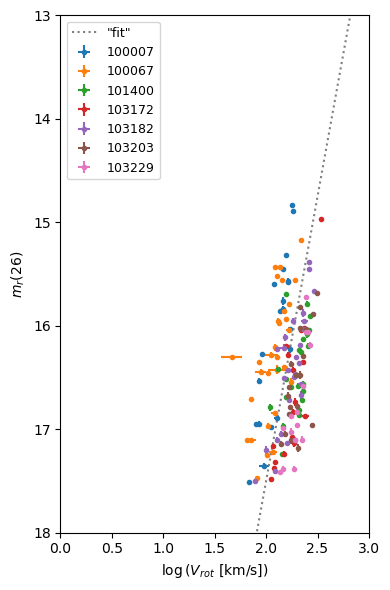

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(4,6), tight_layout=True)

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
logV0 = 0

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[0, 3],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[18, 13],
       ylabel=r'$m_r (26)$')

#- Plot a chi-by-eye fit
a = -5.5
b = 17.5
logV0 = 2.0
_logv = np.arange(0.5, 3., 0.01)
_mr26 = a*(_logv - logV0) + b

ax.plot(_logv, _mr26, ls=':', label='"fit"')

ax.legend(loc='upper left', fontsize=9)

## Apply the Joint TFR Fit

Define a class that performs a joint slope fit across several data sets. This is a modification of the `LinFit` class in the [hyperfit](https://hyperfit.readthedocs.io/en/latest/) package.

Also create a function that encapsulates the fit.

### Maximum Likelihood Fit

Start with a maximum likelihood bounded fit just to test that we can get convergence.

In [33]:
def nlogl(params, datasets, covs):
    """Negative log-likelihood function for joint slope fit to two or more data sets.
    
    Parameters
    ----------
    datasets : list or ndarray
        Mx2xN array of [x1, y1] for each data set.
    cov : ndarray
        Mx2x2xN covariances for each data set.
        
    Returns
    -------
    nloglike : float
        Negative log likelihood of best linear fit.
    """
    m = len(datasets)
    a = params[0]
    b = params[1:m+1]
    sigma = params[m+1]
    
    nloglike = 0.
    for k in np.arange(m): 
        data = datasets[k]
        cov = covs[k]
        x, dx2 = data[0], cov[0,0]
        y, dy2 = data[1], cov[1,1]
        dxy = cov[0,1]
        sy2 = sigma**2 + a**2*dx2 + dy2 - 2*dxy*a
        nloglike += -0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b[k])**2/sy2)
    
    return nloglike

In [34]:
def pack_data(datatab, velname='V_0p4R26', velerrname='V_0p4R26_err', magname='R_MAG_SB26', magerrname='R_MAG_SB26_ERR', logV0=0):
    """Get velocity and magnitude data and pack them into a data and cov vector.

    Parameters
    ----------
    datatab : astropy.table.Table
        Table of data with velocities, magnitudes, etc.
    velname : str
        Name of column with velocity data
    velerrname : str
        Name of column with velocity uncertainties
    magname : str
        Name of column with magnitude data
    magerrname : str
        Name of column with magnitude uncertainties
    logV0 : float
        Pivot point for linear fit, subtracted from velocity

    Returns
    -------
    datak : ndarray
        Data vector storing list of (x,y) values
    covk : ndarray
        Data vector storing list of covariances for each data point
    """
    #- Store independent variable for each cluster
    logv = np.log10(datatab[velname].data) - logV0
    logv_err = 0.434*datatab[velerrname].data / datatab[velname].data

    #- Store dependent variable for each cluster
    mr26 = datatab[magname].data
    mr26_err = datatab[magerrname].data

    #- Fill the data and cov vectors
    n = len(logv)
    corr_logv_mr26 = np.zeros_like(logv)
    
    datak, covk = np.empty((2,n)), np.empty((2,2,n))
    for j, (_x, _y, _ex, _ey, _rhoxy) in enumerate(zip(logv, mr26, logv_err, mr26_err, corr_logv_mr26)):
        covk[:,:,j] = np.array([[_ex**2, _ex*_ey*_rhoxy], [_ex*_ey*_rhoxy, _ey**2]])
        datak[:,j] = [_x, _y]

    return datak, covk

#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
data, cov = [], []

logV0 = 2.25

# Start with the zero-point calibrators
datak, covk = pack_data(zeroptab, 
                        velname='V_0p4R26', velerrname='V_0p4R26_err',
                        magname='R_ABSMAG_SB26', magerrname='R_ABSMAG_SB26_err',
                        logV0=logV0)
data.append(datak)
cov.append(covk)

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    datak, covk = pack_data(caltab[select_cluster],
                            velname='V_0p4R26', velerrname='V_0p4R26_err',
                            magname='R_MAG_SB26', magerrname='R_MAG_SB26_ERR',
                            logV0=logV0)
    data.append(datak)
    cov.append(covk)

# Minimization with BFGS or L-BFGS-B (initial guess needed, Hessian returned):
slope = -7.5
intercepts = [-15] + m*[15]
sigma = 0.25
p0 = [slope] + intercepts + [sigma]

bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

print('\n\nBFGS minimization:')
res = minimize(nlogl, p0, args=(data, cov), bounds=bounds, method='L-BFGS-B')
print(res)



BFGS minimization:
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -353.7622297969415
        x: [-6.454e+00 -2.086e+01  1.514e+01  1.518e+01  1.670e+01
             1.663e+01  1.642e+01  1.687e+01  1.706e+01  5.107e-01]
      nit: 31
      jac: [-1.023e-04 -3.581e-04 -3.979e-04 -8.527e-05  5.457e-04
             8.527e-05  8.242e-04 -5.684e-06 -5.343e-04 -1.063e-03]
     nfev: 528
     njev: 48
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>


#### Plot the Maximum Likelihood Fit

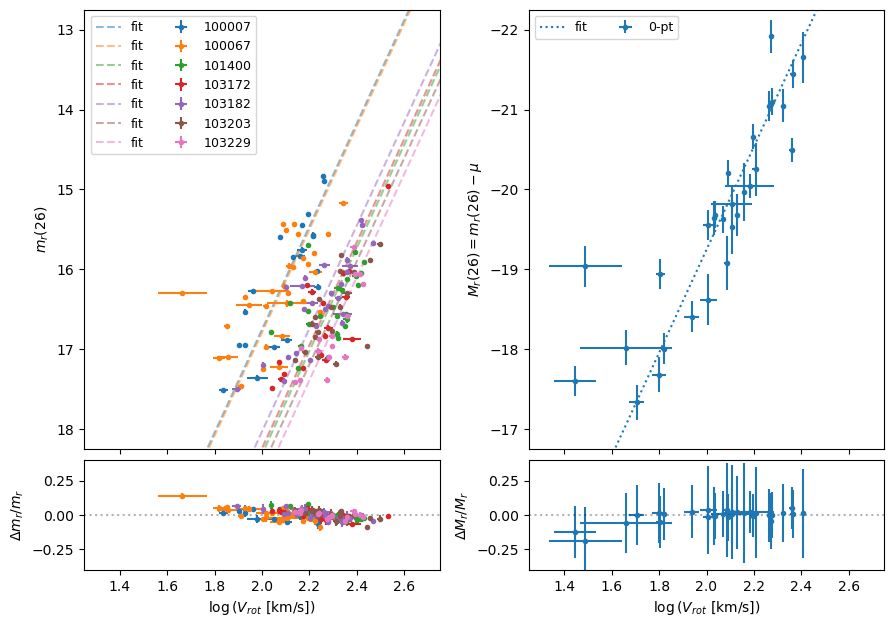

In [35]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = res.x[0]
b0pt = res.x[1]
b_   = res.x[2:m+2]

#- Plot clusters
ax = axes[0,0]

for k in np.arange(m):
    eb = ax.errorbar(x=data[k+1][0] + logV0, y=data[k+1][1], xerr=np.sqrt(cov[k+1][0,0]), yerr=np.sqrt(cov[k+1][1,1]),
                     fmt='.', label=f'{_cluster_ids[k]}')

    _logv = np.arange(0, 3, 0.1) - logV0
    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5, label='fit')

ax.set(xlim=[1.25, 2.75],
       ylim=[18.25, 12.75],
       ylabel=r'$m_r (26)$')
ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=data[0][0] + logV0, y=data[0][1], xerr=np.sqrt(cov[0][0,0]), yerr=np.sqrt(cov[0][1,1]),
                 fmt='.', label=f'0-pt')

_logv = np.arange(0, 3, 0.1) - logV0
ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls=':', label='fit')
ax.set(xlim=[1.25, 2.75],
       ylim=[-16.75, -22.25],
       ylabel=r'$M_r(26) = m_r(26) - \mu$')
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in np.arange(m):
    logv_obs = data[k+1][0]
    m_obs = data[k+1][1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=np.sqrt(cov[k+1][0,0]), yerr=np.sqrt(cov[k+1][1,1]),
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-0.4, 0.4],
       ylabel=r'$\Delta m_r/m_r$')

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = data[0][0]
m_obs = data[0][1]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=np.sqrt(cov[0][0,0]), yerr=np.sqrt(cov[0][1,1]),
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-0.4, 0.4],
       ylabel=r'$\Delta M_r/M_r$')

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
fig.savefig('TF_Y1_cluster_calibration_0pt_fit_ml.png', dpi=150)

### Multiline Fit using HyperFit

Implement a copy of the `LinFit` class from `hyperfit` that jointly fits the same slope to all clusters.

In [36]:
class MultiLinFit:
    """Class to implement linear fits to multiple datasets, assuming
    a common slope but different intercepts across each set.
    
    Based on the hyperfit algorithm of Robotham and Obreschkow (PASP 2015)
    and the Python LinFit implementation of Howlett and Gordon
    (https://hyperfit.readthedocs.io/en/latest/).
    
    Attributes
    ----------
    nsets : int
        Number of data sets and covariances entered by user.
    ndims : int
        Dimensionality of the data (expect 2).
    ndata : ndarray
        Array giving the length of every input data vector.
    params : ndarray
        Best-fit linear parameters for the data sets.
    params_scatter : ndarray
        Best-fit scatters along the y-axis for each data set.
    
    Parameters
    ----------
    datasets : list or ndarray
        An Mx2xN array of 2xN data vectors.
    covs : list or ndarray
        An Mx2x2xN array of 2x2xN covariance matrices.
    weights : ndarray
        Array of weights for each data set. Unit weights if not specified.
    vertaxis : float
        Specify which coordinate axis in data is the 'vertical' one. Defaults to last axis (-1).
    """
    
    def __init__(self, datasets, covs, weights=None, vertaxis=-1):

        # self.nsets = 1
        self.nsets = len(datasets)
        self.ndims = np.shape(datasets[0])[0]
        self.ndata = np.array([np.shape(data)[1] for data in datasets])
        self.datasets = datasets
        self.covs = covs
        self.data = None
        self.cov = None
        
        self.npars = 1 + self.nsets # slope + intercepts + sigmas
        self.params = np.zeros(self.npars)
        self.params_scatter = np.zeros(1)
        
        self.weights = [np.ones(n) for n in self.ndata] if weights is None else weights
        self.vertaxis = vertaxis
        
        self.param_bounds = None      # parameter fit bounds for all data sets
        
    # Log posterior function.
    def _lnpost(self, params):
        lnpost = 0.

        for i in range(self.nsets):
            # Loop over individual data sets. 
            self.data = self.datasets[i]
            self.cov  = self.covs[i]
            
            # Set up parameter and bounds arrays for each data set.
            pars_i = np.array([params[0]] + [params[1+i]] + [params[-1]])
            bounds_i = [self.param_bounds[0]] + \
                       [self.param_bounds[1+i]] + \
                       [self.param_bounds[-1]]

            # Set up weights for each data set.
            weights = self.weights[i]
            
            # Sum over all data sets.
            lnprior = self._lnprior(pars_i, bounds_i)
            lnlike = self._lnlike(pars_i)                
            lnpost += np.sum(weights * lnlike) + lnprior
        
        return lnpost
            
    # Log prior function.
    def _lnprior(self, params, bounds):
        lnprior = 0.
        for i, (param, bound) in enumerate(zip(params.T, bounds)):
            lnprior += np.where(np.logical_or(param < bound[0], param > bound[1]), -np.inf, 0.0)

        return lnprior
    
    # Log likelihood function.
    def _lnlike(self, params):
        a, b, sigma = params

        x, dx2 = self.data[0], self.cov[0,0]
        y, dy2 = self.data[1], self.cov[1,1]
        dxy = self.cov[0,1]
        sy2 = sigma**2 + a**2*dx2 + dy2 - 2*dxy*a
        lnlike = 0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b)**2/sy2)

        return lnlike
    
    def bessel_cochran(self, sigma):
        """Bessel-Cochran correction of sample scatter to population scatter.
        
        Parameters
        ----------
        sigma : ndarray
            1xM array of scatters for the M input datasets.
        
        Returns
        -------
        sigma_corr : ndarray
            1xM array of corrected scatter parameters.
        """
        N = np.sum(self.ndata)
        sigma_corr = (
            np.sqrt(0.5 * N)
            * np.exp(loggamma(0.5 * (N - self.ndims)) - loggamma(0.5 * (N - self.ndims + 1.0)))
        ) * sigma

        return sigma_corr
    
    def optimize(self, bounds, tol=1e-6, verbose=False):
        """Find the best-fit line for multiple datasets, assuming a
        common slope across all sets but independent intercepts and scatters.
        
        Parameters
        ----------
        bounds : sequence
            Bounds for variables [a, b1, ..., bm, sig1, ..., sigm].
        tol : float
            Optimization tolerance.
        verbose : bool
            Print fit result.
            
        Returns
        -------
        params : ndarray
            Array of best-fit slope and intercepts [a, b1, b2, ..., bm]
        params_scatter : ndarray
            Array of vertical axis scatter parameters [sig1, sig2, ... sigm]
        log_posterior : float
            Value of ln(posterior) at the best fit point.
        """
        self.param_bounds = bounds
        res = differential_evolution(lambda *args: -self._lnpost(*args), self.param_bounds, tol=tol)

        if verbose:
            print(res)
            
        self.params = res.x[:-1]
        self.params_scatter = np.fabs(res.x[-1])
        self.params_scatter = self.bessel_cochran(self.params_scatter)
        return self.params, self.params_scatter, -res.fun
    
    def emcee(self, bounds, max_iter=100000, batchsize=1000, ntau=50.0, tautol=0.05, skip_initial_state_check=False, verbose=False):
        """Run MCMC using the emcee EnsembleSampler.
        
        The MCMC is seeded using a randomization of the best-fit values of the
        common slope, intercepts, and vertical scatters [a, b1, ..., bm, sig1, ..., sigm].
        
        Parameters
        ----------
        bounds : sequence
            Bounds for variables [a, b1, ..., bm, sig1, ..., sigm].
        max_iter : int
            Maximum number of MCMC iterations.
        batchsize : int
            Size of each batch. Convergence checked after each batch.
        ntau : float
            Minimum autocorrelation length to consider for convergence.
        tautol : float
            Maximum fractional deviation between successive autocorrelation lengths for convergence.
        skip_initial_state_check : boolean
            Whether or not to check the initial state.  Default is False (check state).
        verbose : bool
            Print out convergence statistics and progress bars if True.
            
        Returns
        -------
        mcmc_samples : ndarray
            Array of flattened and burned-in MCMC samples.
        mcmc_lnlike : ndarray
            Log-likelihood values of every MCMC sample.
        """

        # Set up emcee. Start the walkers in a small 1 percent ball around the best fit.
        # The best fit will set self.params and self.params_scatter.
        self.optimize(bounds, verbose=verbose)
        ndim = len(self.params) + 1 #len(self.params_scatter)
        nwalker = 4 * ndim
        seeds = np.asarray([
            [(0.01 * np.random.rand() + 0.995) * j for j in np.concatenate([self.params, [self.params_scatter]])]
            for _ in range(nwalker)
        ])
        
        if np.any(np.isinf(seeds)):
            print('Some of the seeds are infinite!')
        elif np.any(np.isnan(seeds)):
            print('Some of the seeds are NaN!')

        print(f'Ndim: {ndim} {self.nsets}')
        sampler = emcee.EnsembleSampler(nwalker, ndim, self._lnpost)

        old_tau = np.inf
        niter = 0
        converged = 0
        while ~converged:
            sampler.run_mcmc(seeds, nsteps=batchsize, progress=verbose, skip_initial_state_check=skip_initial_state_check)
            tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
            converged = np.all(ntau * tau < niter)
            converged &= np.all(np.abs(old_tau - tau) / tau < tautol)
            old_tau = tau
            begin = None
            niter += 1000
            if verbose:
                print("Niterations/Max Iterations: ", niter, "/", max_iter)
                print("Integrated ACT/Min Convergence Iterations: ", tau, "/", np.amax(ntau * tau))
            if niter >= max_iter:
                break

        # Remove burn-in and and save the samples
        tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
        burnin = int(2 * np.max(tau))
        samples = sampler.get_chain(discard=burnin, flat=True).T
        mcmc_samples = samples
        mcmc_lnlike = sampler.get_log_prob(discard=burnin, flat=True)

        return mcmc_samples, mcmc_lnlike

In [37]:
#- Initialize and test the multiline fit class.
mlf = MultiLinFit(data, cov)

mlf.params_scatter, mlf.ndata, mlf.ndims, mlf.npars

(array([0.]), array([29, 20, 30, 23, 17, 27, 19, 15]), 2, 9)

In [38]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

#- Perform optimization using differential evolution (no initial guess required).
mlf.optimize(bounds, verbose=True)

 message: Optimization terminated successfully.
 success: True
     fun: -8250.779072214405
       x: [-6.410e+00 -2.085e+01  1.515e+01  1.518e+01  1.670e+01
            1.663e+01  1.642e+01  1.686e+01  1.706e+01  5.193e-01]
     nit: 125
    nfev: 19032
     jac: [-8.313e-02 -6.930e-02 -6.839e-02 -6.294e-02  8.731e-03
           -2.201e-02 -2.638e-02 -2.146e-02  7.276e-04  6.057e-02]


(array([ -6.40970818, -20.85320055,  15.14506924,  15.18418422,
         16.69659824,  16.6280003 ,  16.41678945,  16.86320459,
         17.06280712]),
 0.5229586859591769,
 8250.779072214405)

In [39]:
#- Run the MCMC
mcmc_samples, mcmc_lnlike = mlf.emcee(bounds, max_iter=20000, verbose=True)#, skip_initial_state_check=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

 message: Optimization terminated successfully.
 success: True
     fun: -8250.779085181553
       x: [-6.408e+00 -2.085e+01  1.515e+01  1.518e+01  1.670e+01
            1.663e+01  1.642e+01  1.686e+01  1.706e+01  5.192e-01]
     nit: 134
    nfev: 20393
     jac: [ 9.259e-02  6.003e-03  5.457e-04  2.237e-02 -8.731e-03
           -3.820e-02 -6.894e-02 -5.039e-02 -5.693e-02  6.858e-02]
Ndim: 10 8


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 179.96it/s]


Niterations/Max Iterations:  1000 / 20000
Integrated ACT/Min Convergence Iterations:  [57.6355728  51.5145842  55.83092114 55.84533742 51.05928875 49.09594238
 57.21213737 52.85823244 61.75772278 52.5888957 ] / 3087.8861391082073


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.08it/s]


Niterations/Max Iterations:  2000 / 20000
Integrated ACT/Min Convergence Iterations:  [69.58643628 68.35673838 69.45597504 66.11792789 56.91382711 63.77592065
 65.15915143 67.45694014 68.32274921 88.35001784] / 4417.50089181856


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.84it/s]


Niterations/Max Iterations:  3000 / 20000
Integrated ACT/Min Convergence Iterations:  [73.94612692 85.71703869 77.56311397 70.96380781 75.79511317 68.22281965
 71.68941263 77.61925377 74.46950971 85.23920129] / 4285.851934264271


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 182.15it/s]


Niterations/Max Iterations:  4000 / 20000
Integrated ACT/Min Convergence Iterations:  [91.66476416 86.11102709 80.48308205 73.97322472 76.92654538 79.49886764
 78.78919078 92.04593016 83.1380075  84.53266181] / 4602.296508132472


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.28it/s]


Niterations/Max Iterations:  5000 / 20000
Integrated ACT/Min Convergence Iterations:  [89.34975333 87.57110803 82.45810186 85.46497313 83.64539631 82.51491143
 76.43433713 92.09380954 77.78407136 84.4910166 ] / 4604.690477070015


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.78it/s]


Niterations/Max Iterations:  6000 / 20000
Integrated ACT/Min Convergence Iterations:  [101.66499682  91.88812052  83.19109387  97.69422659  84.21897509
  85.40840091  85.71392075  97.78504334  72.71122311  92.97884759] / 5083.249840841896


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.28it/s]


Niterations/Max Iterations:  7000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 95.06266965  92.04063088  93.56908699 104.90392892  91.68767166
  93.14676391  94.36393044  99.83360859  79.93320762  95.49811567] / 5245.196446083893


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.13it/s]


Niterations/Max Iterations:  8000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 95.7762937   92.47066508  90.78989927 104.38773097 100.08169698
  98.77075246  93.78132958 101.39712972  81.87505934  97.77511458] / 5219.386548613297


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 180.71it/s]


Niterations/Max Iterations:  9000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 96.75180275  93.21597595  93.34069471 109.47903377  99.4028329
 107.15813686  96.01266434 101.0014179   89.00302921  98.79964008] / 5473.951688658702


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 181.32it/s]


Niterations/Max Iterations:  10000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 92.25056912  92.71484889 100.74923903 106.91625979  94.45706441
 105.3037386   97.48142128 102.36459546  98.48287485  93.59483004] / 5345.81298967049


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 180.68it/s]


Niterations/Max Iterations:  11000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 90.20031303  94.80758725 102.94157014 101.49388399  99.9754158
 107.58788255 101.28995026  99.9447067   96.36209187  92.62303202] / 5379.394127335317


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 176.68it/s]


Niterations/Max Iterations:  12000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 96.46045311  92.48333011 103.80003724 106.66185464  98.21056199
 104.05081833 102.53940629  96.43616215 101.40910279  93.96144554] / 5333.09273211555


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 175.34it/s]


Niterations/Max Iterations:  13000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 95.94696683  94.02713561 100.15520996 101.0181298   97.89253628
 100.7121743  103.96565194  94.43683705 108.53676074  94.73688382] / 5426.838037057847


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 176.62it/s]


Niterations/Max Iterations:  14000 / 20000
Integrated ACT/Min Convergence Iterations:  [ 96.85410663  95.81631081 100.90223615  95.7525556  104.74965508
 100.28243586  99.65595228  94.92146551 109.89275349  92.38893016] / 5494.637674662946


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 173.48it/s]


Niterations/Max Iterations:  15000 / 20000
Integrated ACT/Min Convergence Iterations:  [100.82825364  97.19675869  99.93761247  93.71531689 103.061679
 101.98211408 102.18596217  94.49594578 106.33035239  97.07581282] / 5316.517619426099
[ -6.41809404 -20.85510804  15.1443254   15.18251548  16.69696276
  16.62737442  16.41642144  16.86315275  17.06319999   0.52096406] [0.07248798 0.02454799 0.02898534 0.02223003 0.02323949 0.03168029
 0.02009183 0.02850744 0.03568263 0.00815966]


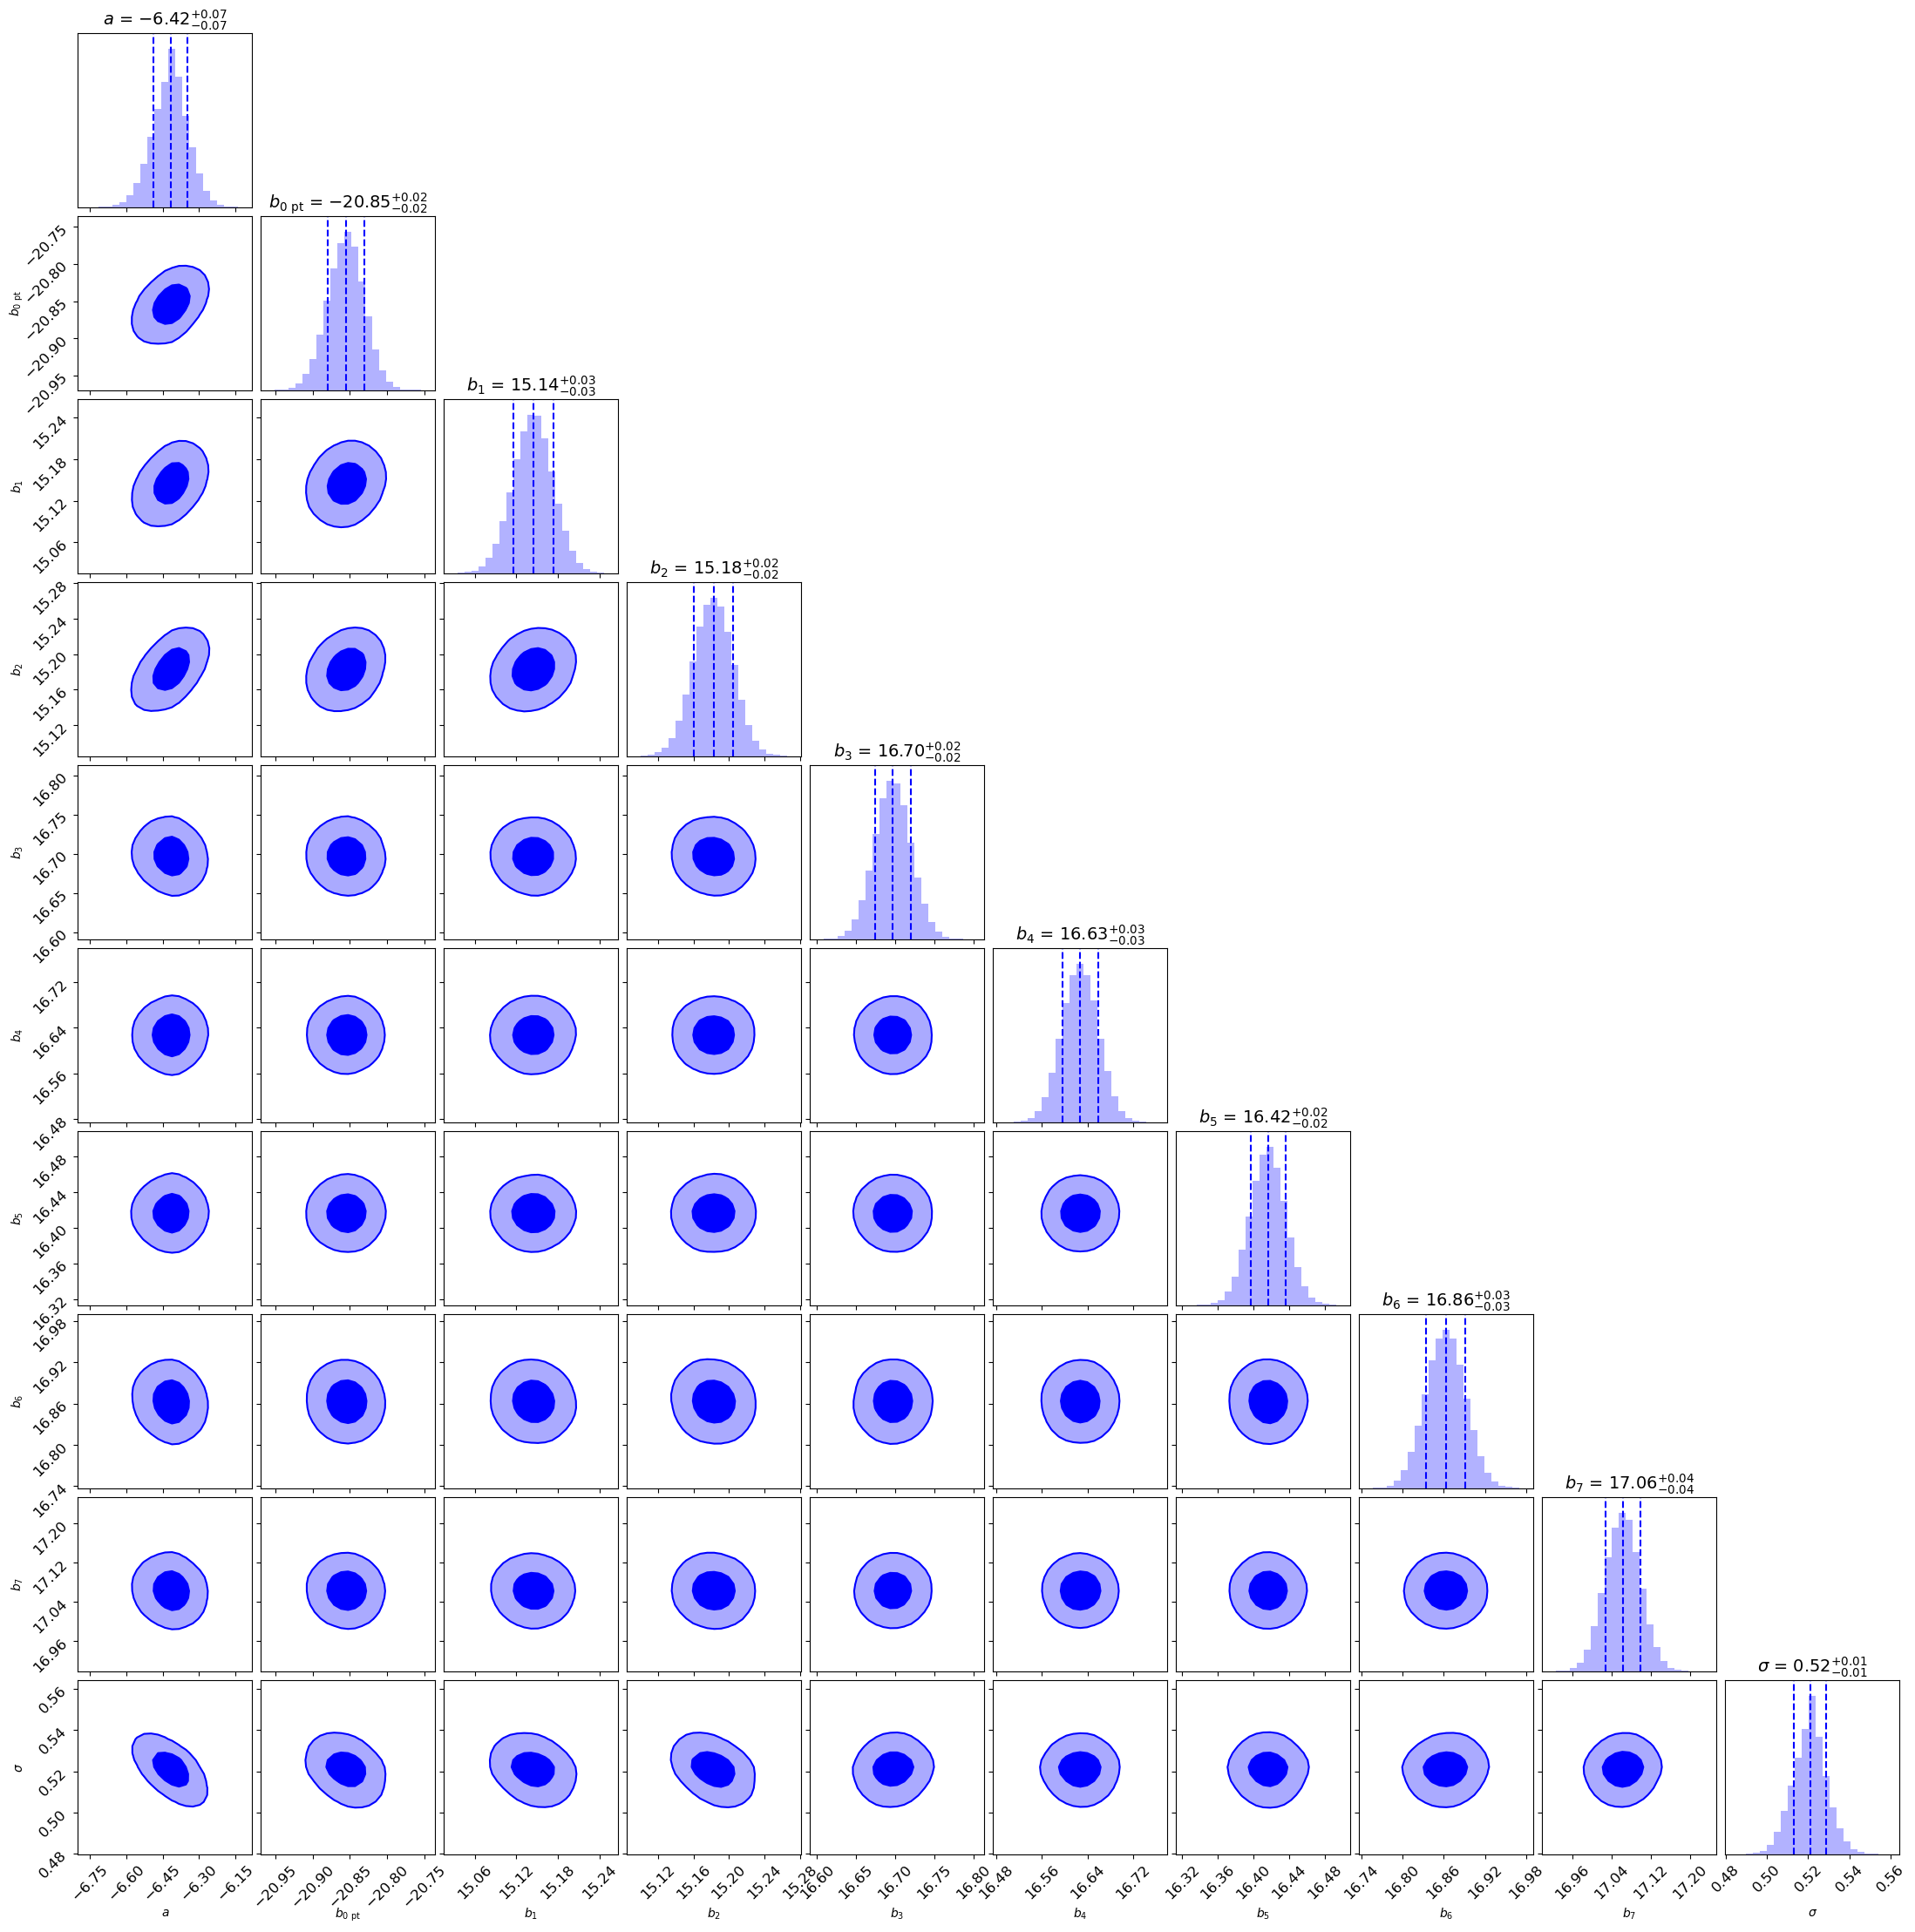

In [40]:
labels  = ['$a$']
labels += ['$b_{0~\mathrm{pt}}$'] + [f'$b_{k+1}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 14})

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig('TF_Y1_cluster_calibration_corner_no0pt.png', dpi=150);

#### Plot the HyperFit Results

In [41]:
sigma_mcmc = np.percentile(mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in np.arange(1, m+2):
    b_mcmc.append(np.percentile(mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

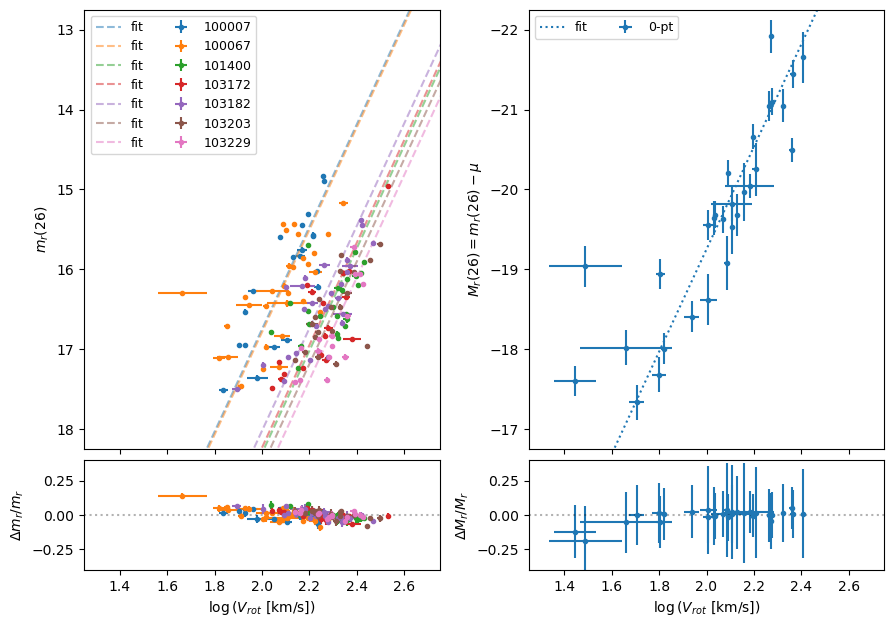

In [42]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

for k in np.arange(m):
    eb = ax.errorbar(x=data[k+1][0] + logV0, y=data[k+1][1], xerr=np.sqrt(cov[k+1][0,0]), yerr=np.sqrt(cov[k+1][1,1]),
                     fmt='.', label=f'{_cluster_ids[k]}')

    _logv = np.arange(0, 3, 0.1) - logV0
    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5, label='fit')

ax.set(xlim=[1.25, 2.75],
       ylim=[18.25, 12.75],
       ylabel=r'$m_r (26)$')
ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=data[0][0] + logV0, y=data[0][1], xerr=np.sqrt(cov[0][0,0]), yerr=np.sqrt(cov[0][1,1]),
                 fmt='.', label=f'0-pt')

_logv = np.arange(0, 3, 0.1) - logV0
ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls=':', label='fit')
ax.set(xlim=[1.25, 2.75],
       ylim=[-16.75, -22.25],
       ylabel=r'$M_r(26) = m_r(26) - \mu$')
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in np.arange(m):
    logv_obs = data[k+1][0]
    m_obs = data[k+1][1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=np.sqrt(cov[k+1][0,0]), yerr=np.sqrt(cov[k+1][1,1]),
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-0.4, 0.4],
       ylabel=r'$\Delta m_r/m_r$')

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = data[0][0]
m_obs = data[0][1]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=np.sqrt(cov[0][0,0]), yerr=np.sqrt(cov[0][1,1]),
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-0.4, 0.4],
       ylabel=r'$\Delta M_r/M_r$')

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
fig.savefig('TF_Y1_cluster_calibration_0pt_fit_mcmc.png', dpi=150)